# 1. Introduction
Breast cancer is one of the most common cancers worldwide, making early and accurate diagnosis crucial for effective treatment and improved patient outcomes. The Wisconsin Breast Cancer Dataset (WBCD) is widely used for research in medical diagnostics and machine learning due to its well-structured features and labeled outcomes. This dataset provides detailed information about cell characteristics extracted from digitized images of fine needle aspirate (FNA) biopsies of breast masses.

The dataset consists of 30 numerical features describing various cell properties, including radius, texture, perimeter, and smoothness, among others. These features are used to classify tumors as either malignant (cancerous) or benign (non-cancerous). Given its binary classification nature, the dataset serves as an excellent resource for exploring various machine learning techniques, including logistic regression, decision trees, support vector machines, and deep learning models.

In this analysis, we aim to:

  -  Understand the dataset by exploring the distribution of features and their correlation with the diagnosis.
  -  Perform data preprocessing to handle missing values, standardize numerical features, and prepare the data for modeling.
  -  Apply machine learning models to classify breast tumors and evaluate their performance using metrics such as accuracy, precision,     recall, and F1-score.
  -  Interpret model results to determine the most important features contributing to breast cancer classification.

By leveraging statistical techniques and machine learning, this study seeks to enhance the understanding of breast cancer diagnosis and contribute to the development of more accurate predictive models for early detection.

In [1]:
librarian::shelf(tidyverse,skimr, tidymodels, corrplot, GGally, viridis, patchwork, scales,
   gridExtra, ggridges, vip, ggbiplot, factoextra, finetune, kernlab, ranger, xgboost, janitor,
    Boruta, PCAtest, summarytools, tictoc, kableExtra, ggpubr, betacal)

In [2]:
cancer_data <- read_csv("../datasets/Cancer_Data.csv") %>%
    select(-id, -starts_with("..."))

New names:
• `` -> `...33`
Rows: 568 Columns: 33
── Column specification ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr  (1): diagnosis
dbl (31): id, radius_mean, texture_mean, perimeter_mean, area_mean, smoothness_mean, compactness_mean, concavity_mean, concave points_mean, symmet...
lgl  (1): ...33

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Warning message:
One or more parsing issues, call `problems()` on your data frame for details, e.g.:
  dat <- vroom(...)
  problems(dat) 


In [3]:
# Set custom theme

theme_custom <- function() {
  theme_minimal() +
    theme(
      plot.background = element_rect(fill = "white", color = NA),
      panel.grid.major = element_line(color = "gray90"),
      panel.grid.minor = element_blank(),
      plot.title = element_text(size = 16, face = "bold", hjust = 0.5),
      plot.subtitle = element_text(size = 12, color = "gray30", hjust = 0.5),
      axis.title = element_text(size = 12, face = "bold"),
      axis.text = element_text(size = 10),
      legend.title = element_text(size = 12, face = "bold"),
      legend.text = element_text(size = 10),
      legend.position = "right"
    )
}

theme_set(theme_custom())



In [4]:
# Convert diagnosis to factor (B = Benign, M = Malignant)
cancer_data <- cancer_data %>% 
  janitor::clean_names() %>% 
  mutate(diagnosis = factor(if_else(diagnosis == "M", "Malignant", "Benign")))

In [6]:
skim(cancer_data) %>% 
  as_tibble() %>% 
  select(-n_missing) %>% 
  kableExtra::kable() -> summary_table

print(summary_table)




|skim_type |skim_variable           | complete_rate|factor.ordered | factor.n_unique|factor.top_counts  | numeric.mean|  numeric.sd| numeric.p0| numeric.p25| numeric.p50| numeric.p75| numeric.p100|numeric.hist |
|:---------|:-----------------------|-------------:|:--------------|---------------:|:------------------|------------:|-----------:|----------:|-----------:|-----------:|-----------:|------------:|:------------|
|factor    |diagnosis               |             1|FALSE          |               2|Ben: 356, Mal: 212 |           NA|          NA|         NA|          NA|          NA|          NA|           NA|NA           |
|numeric   |radius_mean             |             1|NA             |              NA|NA                 |   14.1385018|   3.5169865|  6.981e+00|  11.7075000|  13.3750000| 1.57975e+01|    2.811e+01|▂▇▃▁▁        |
|numeric   |texture_mean            |             1|NA             |              NA|NA                 |   19.2804049|   4.2991664|  9.710e+00|  16.1

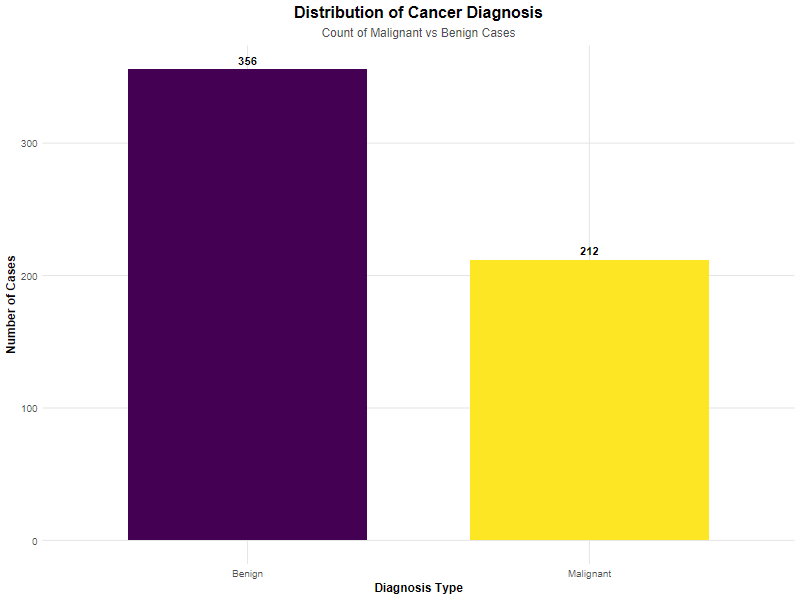

In [6]:
# 1.1 Class Distribution
diagnosis_counts <- cancer_data %>% 
  count(diagnosis) %>%
  mutate(percentage = n / sum(n) * 100)

ggplot(cancer_data, aes(diagnosis, fill = diagnosis)) +
    geom_bar(width = 0.7) +
    geom_text(stat = "count", 
             aes(label = after_stat(count)),
             vjust = -0.5,
             size = 4, fontface = "bold") +
    scale_fill_viridis_d(option = "D") +
    labs(title = "Distribution of Cancer Diagnosis",
       subtitle = "Count of Malignant vs Benign Cases",
       x = "Diagnosis Type",
       y = "Number of Cases") +
    theme_custom() +
    theme(legend.position = "none") -> diagnosis_plot
ggsave(filename = "../results/diagnosis_distribution.png", plot = diagnosis_plot, width = 8, height = 6, dpi = 300)

diagnosis_plot

**Observations**
1. Benign Cases (Dark Purple Bar - Left):

    - The dataset contains 356 benign cases.
    - Benign tumors are non-cancerous and typically do not spread to other parts of the body.

2. Malignant Cases (Yellow Bar - Right):

   - The dataset includes 212 malignant cases.
   - Malignant tumors are cancerous and require early detection and treatment to prevent progression.

3. Class Imbalance:

   - The dataset has more benign cases than malignant cases, meaning that a machine learning model trained - - on this data may lean towards predicting benign cases more often unless class balancing techniques (such as oversampling, undersampling, or class weighting) are applied.

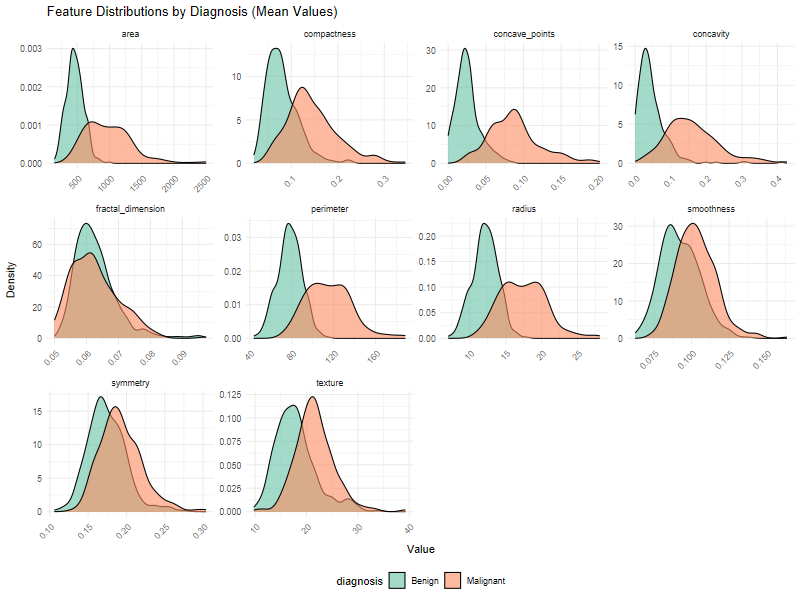

In [7]:
# 1.2 Feature Distribution by Diagnosis (for mean features)
# Let's reshape the cancer_data for visualization
mean_features <- cancer_data %>%
  select(diagnosis, contains("_mean")) %>%
  pivot_longer(cols = -diagnosis, 
               names_to = "feature", 
               values_to = "value") %>%
  mutate(feature = str_remove(feature, "_mean"))

# Visualize mean feature distributions
p2 <- ggplot(mean_features, aes(x = value, fill = diagnosis)) +
  geom_density(alpha = 0.6) +
  facet_wrap(~ feature, scales = "free") +
  labs(title = "Feature Distributions by Diagnosis (Mean Values)",
       x = "Value", y = "Density") +
  scale_fill_manual(values = c("Benign" = "#66c2a5", "Malignant" = "#fc8d62")) +
  theme_minimal() +
  theme(axis.text.x = element_text(angle = 45, hjust = 1),
        legend.position = "bottom")
ggsave(filename = "../results/mean_feature_distribution.png", plot = p2, width = 8, height = 6, dpi = 300)

p2

**Observations**    
1. Feature Separation:
      -  Some features show clear separation between benign and malignant cases.
      -  Features like concave points, concavity, perimeter, radius, and area have higher values for  malignant tumors and lower values for benign tumors.
      -  This suggests these features are strong indicators for cancer diagnosis.

2. Overlapping Distributions:
      -  Some features, like smoothness, symmetry, and texture, have overlapping distributions between benign and malignant cases.
      -  These features alone may not be as effective in distinguishing between the two diagnoses.

3. Right-Skewed Distributions:
       - Features such as area, perimeter, radius, concavity, and concave points show a longer tail on the right for malignant cases, indicating that malignant tumors tend to have higher values for these attributes.

4. Compactness and Fractal Dimension:
      -  These features also have noticeable differences, but their distributions have more overlap, meaning they might still contribute to classification but not as strongly as other features.

**Implications for Machine Learning Models**:

i. Features like concavity, perimeter, radius, area, and concave points could be important predictors for distinguishing malignant from benign tumors.

ii. Some features may require feature selection or transformation techniques to improve model performance.

iii. A classification model trained on these features should consider using feature importance analysis (e.g., Random Forest feature importance, PCA, or correlation analysis) to focus on the most relevant features.


Attaching package: ‘corrr’

The following object is masked from ‘package:skimr’:

    focus

Correlation computed with
• Method: 'pearson'
• Missing treated using: 'pairwise.complete.obs'


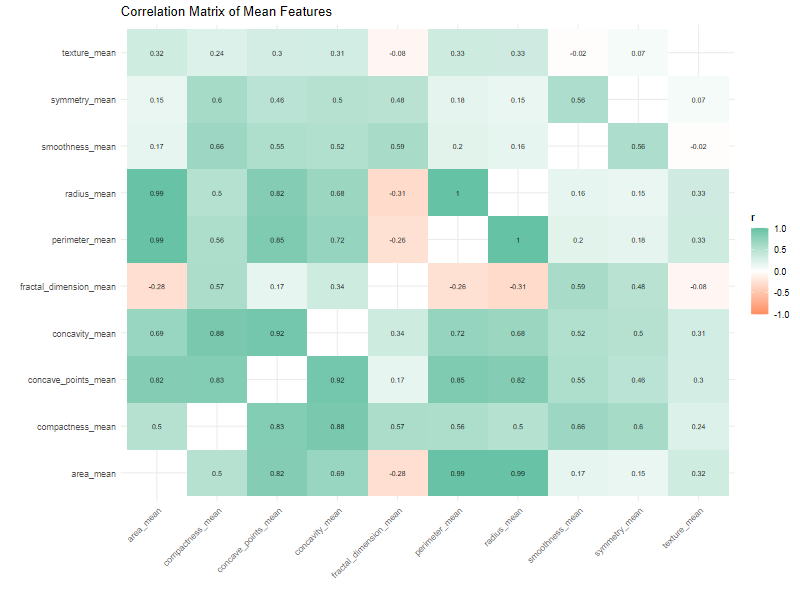

In [7]:
library(corrr)
# 1.3 Correlation Analysis (mean features)
corr_matrix <- cancer_data %>%
  select(contains("_mean")) %>%
  correlate() %>%
  rearrange()

# Visualize correlation matrix
p3 <- corr_matrix %>%
  stretch() %>%
  filter(abs(r) > 0.0) %>%
  ggplot(aes(x = x, y = y, fill = r)) +
  geom_tile() +
  geom_text(aes(label = round(r, 2)), size = 2.5) +
  scale_fill_gradient2(low = "#fc8d62", mid = "white", high = "#66c2a5", 
                       midpoint = 0, limits = c(-1, 1)) +
  labs(title = "Correlation Matrix of Mean Features",
       x = "", y = "") +
  theme_minimal() +
  theme(axis.text.x = element_text(angle = 45, hjust = 1))
ggsave(filename = "../results/correlation(mean features).png", plot = p3, width = 8, height = 6, dpi = 300)
p3

**Observations**

1. Strong Positive Correlations (Close to 1, Dark Green)

    Radius_mean, Perimeter_mean, and Area_mean are highly correlated (~0.99).
        This makes sense since a larger radius leads to a larger perimeter and area.
    Concavity_mean, Concave_points_mean, and Compactness_mean show strong positive correlations (~0.83 to 0.88).
        These features relate to how irregular and concave the tumor boundaries are.

2. Strong Negative Correlations (Close to -1, Dark Orange)

    Fractal_dimension_mean has a negative correlation with features like radius_mean (-0.31) and perimeter_mean (-0.26).
        This might indicate that as tumors become larger, their boundaries tend to be less fractal-like.

3. Weak or No Correlation (Close to 0, Light Colors)

    Texture_mean and Smoothness_mean show weak correlations with most features (~0.07 to 0.33).
        These features may be more independent in the dataset.

Key Insights:

- Highly correlated features might contain redundant information, which could be removed to avoid multicollinearity in a machine learning model.
- Features like fractal_dimension_mean show an inverse relationship with tumor size metrics, which could be important for classification.

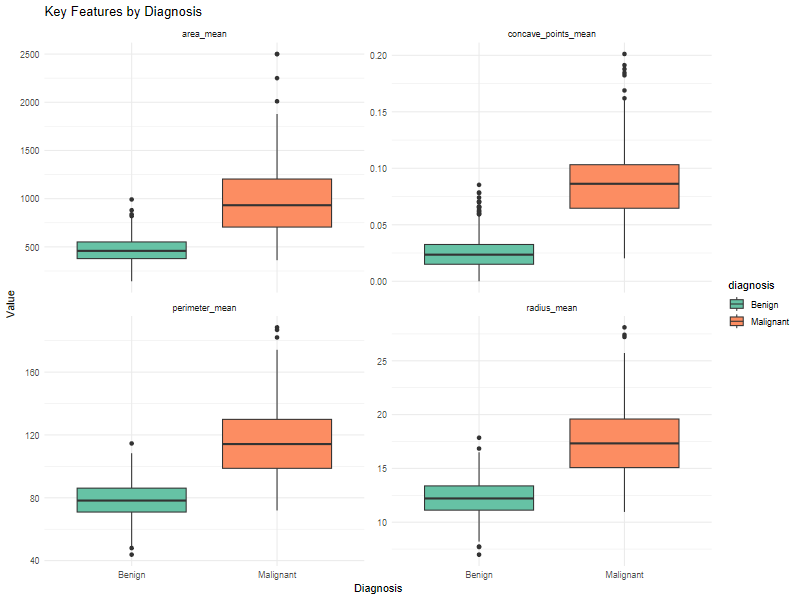

In [9]:
# 1.4 Box plots for key diagnostic features
key_features <- c("radius_mean", "concave_points_mean", "perimeter_mean", "area_mean")
key_cancer_data <- cancer_data %>%
  select(diagnosis, all_of(key_features)) %>%
  pivot_longer(cols = -diagnosis, 
               names_to = "feature", 
               values_to = "value")

p4 <- ggplot(key_cancer_data, aes(x = diagnosis, y = value, fill = diagnosis)) +
  geom_boxplot() +
  facet_wrap(~ feature, scales = "free_y") +
  labs(title = "Key Features by Diagnosis",
       x = "Diagnosis", y = "Value") +
  scale_fill_manual(values = c("Benign" = "#66c2a5", "Malignant" = "#fc8d62")) +
  theme_minimal()
  ggsave(filename = "../results/Key Features by Diagnosis.png", plot = p4, width = 8, height = 6, dpi = 300)
p4

**Observations**    
1. Area Mean:
- Malignant tumors tend to have significantly larger area values compared to benign tumors.
- The interquartile range (IQR) and median are higher for malignant cases.
- There are several outliers for malignant tumors with extremely high area values.

2. Perimeter Mean:
- Malignant tumors have a higher perimeter on average.
- A clear separation is observed between benign and malignant cases, with the malignant group having a wider distribution.
- Outliers exist in both groups, but malignant cases show extreme values.

3. Concave Points Mean:
- Malignant tumors tend to have more concave points, which means they have more irregular, concave-shaped boundaries.
- There are many outliers in the malignant group, suggesting variability in this feature.

4. Radius Mean:
- Malignant tumors have a larger average radius compared to benign ones.
- This further supports the correlation seen in the previous correlation matrix—radius, perimeter, and area are highly correlated.

***Key Insights***:

- All four features show clear separation between benign and malignant tumors.
- Area, perimeter, and radius are strongly correlated, meaning they may contribute redundant information in a predictive model.
- Concave points mean is an important feature, as it captures tumor boundary irregularities, a strong sign of malignancy.

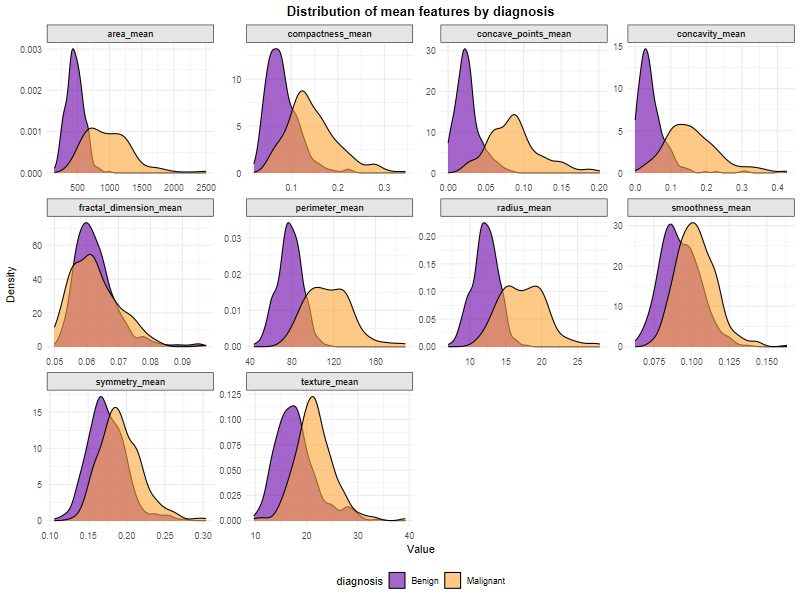

In [10]:
options(repr.plot.height = 12, repr.plot.width = 12)
# select mean features for visualization
mean_features <- cancer_data %>%
  select(diagnosis, contains("mean"))

# Reshape cancer_data for visualization
mean_features_long <- mean_features %>%
  pivot_longer(cols = -diagnosis, 
               names_to = "feature", 
               values_to = "Value")

# Strip "mean_" prefix for cleaner visualization
mean_features_long$feature <- gsub("mean_", "", mean_features_long$feature)

# Create density plots for each feature by diagnosis
ggplot(mean_features_long, aes(x = Value, fill = diagnosis)) +
  geom_density(alpha = 0.6) +
  facet_wrap(~ feature, scales = "free") +
  theme_minimal() +
  labs(title = "Distribution of mean features by diagnosis",
       X = "Value", y = "Density") +
  scale_fill_viridis_d(option = "plasma", begin = 0.2, end = 0.8) +
  theme(legend.position = "bottom",
        plot.title = element_text(hjust = 0.5, face = "bold"),
        strip.background = element_rect(fill = "gray90"),
        strip.text = element_text(face = "bold")) -> p5
ggsave(filename = "../results/mean_feature_distribution_by_diagnosis.png", plot = p5, width = 8, height = 6, dpi = 300)
p5

**Observation**
- area_mean, perimeter_mean, radius_mean: Malignant tumors tend to have higher values, indicating that they are generally larger in size compared to benign tumors.
concavity_mean, concave_points_mean, compactness_mean: Malignant tumors exhibit a higher concentration of these values, suggesting that they have more irregular and invasive boundaries.
- fractal_dimension_mean: The distributions are more overlapping, indicating that this feature may not be as strongly discriminative as others.
- smoothness_mean, symmetry_mean, texture_mean: These features show some degree of separation, but not as distinct as size and shape-related metrics.

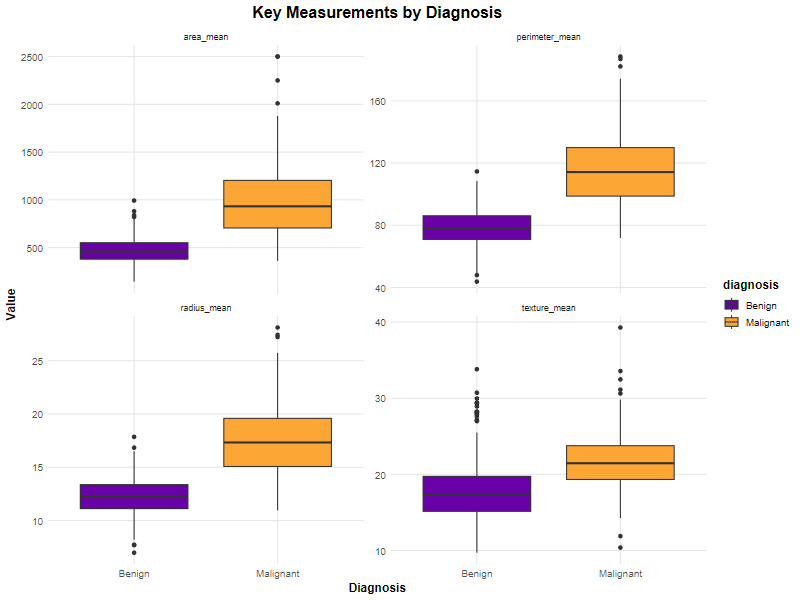

In [8]:
cancer_data %>%
  pivot_longer(cols = c(radius_mean, texture_mean, perimeter_mean, area_mean),
               names_to = "measurement",
               values_to = "value") %>%
  ggplot(aes(x = diagnosis, y = value, fill = diagnosis)) +
  geom_boxplot() +
  facet_wrap(~measurement, scales = "free_y") +
  theme_custom() +
  scale_fill_viridis_d(option = "plasma", begin = 0.2, end = 0.8) +
  labs(title = "Key Measurements by Diagnosis",
       
       x = "Diagnosis",
       y = "Value") -> p6
ggsave(filename = "../results/Key Measurements by Diagnosis.png", plot = p6, width = 8, height = 6, dpi = 300)
p6

Picking joint bandwidth of 20.3


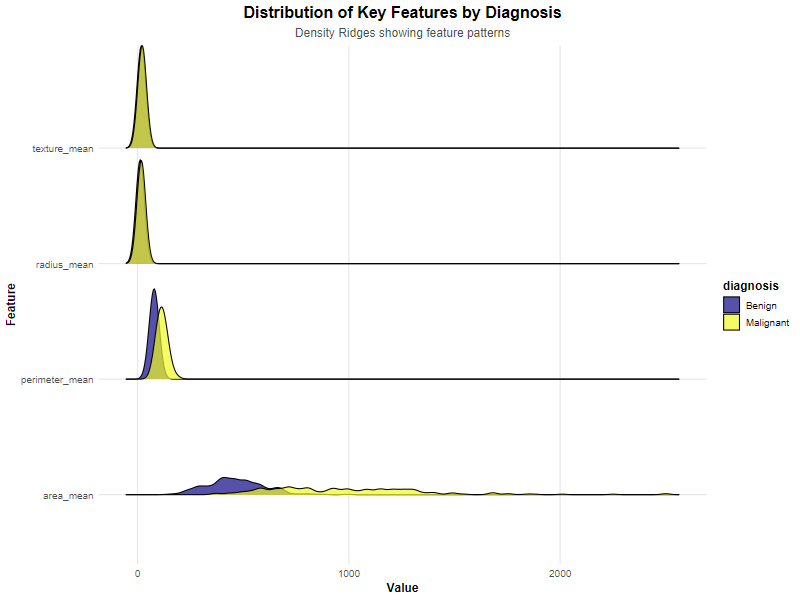

Picking joint bandwidth of 20.3

In [9]:
## Feature Density

selected_features <- c("radius_mean", "texture_mean", "perimeter_mean", "area_mean")

cancer_data %>%
    pivot_longer(cols = all_of(selected_features),
               names_to = "feature",
               values_to = "value") %>%
    ggplot(aes(value, feature, fill = diagnosis)) +
    geom_density_ridges(alpha = 0.7, scale = 0.9) +
    scale_fill_viridis_d(option = "C") +
    labs(title = "Distribution of Key Features by Diagnosis",
       subtitle = "Density Ridges showing feature patterns",
       x = "Value",
       y = "Feature") +
    theme_custom() -> p7
ggsave(filename = "../results/Distribution of Key Features by Diagnosis.png", plot = p7, width = 8, height = 6, dpi = 300)
p7

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


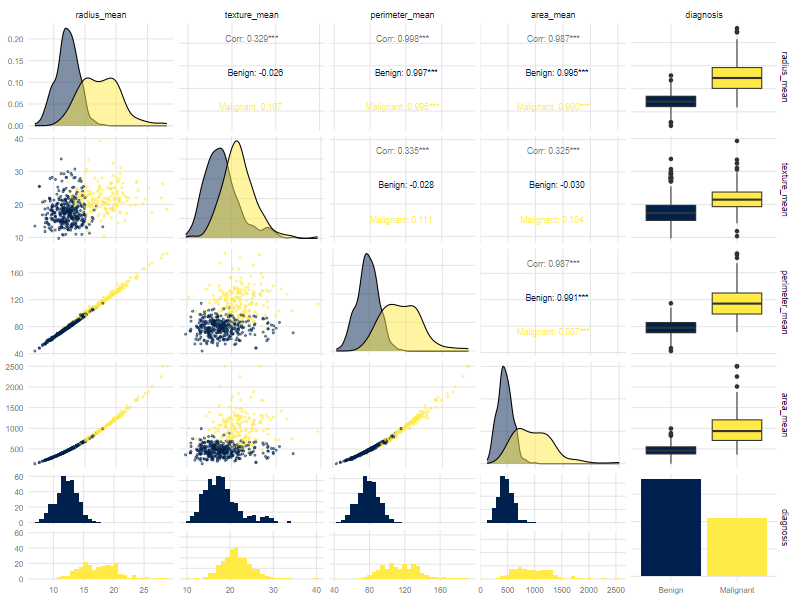

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

In [10]:
## Scatter Matrix

cancer_data %>%
    select(all_of(selected_features), diagnosis) %>%
    ggpairs(aes(color = diagnosis),
                  upper = list(continuous = wrap("cor", size = 3)),
                  diag = list(continuous = wrap("densityDiag", alpha = 0.5)),
                  lower = list(continuous = wrap("points", alpha = 0.5, size = 0.8))) +
    scale_fill_viridis_d(option = "E") +
    scale_color_viridis_d(option = "E") +
    theme_custom() +
    theme(axis.text = element_text(size = 8)) -> p8
ggsave(filename = "../results/Scatter Matrix.png", plot = p8, width = 8, height = 6, dpi = 300)
p8

**Insights**
- Density Plots: Malignant tumors (yellow) generally have larger radius, perimeter, and area values than benign tumors (dark blue), indicating that tumor size is a strong differentiator.
- Scatter Plots: There is a strong positive correlation between radius_mean, perimeter_mean, and area_mean, meaning that as one of these increases, the others tend to increase as well.
- Histograms: The feature distributions show a clear distinction between benign and malignant cases, with malignant tumors having higher values.
- Boxplots: Malignant tumors exhibit higher median values for radius, perimeter, and area, but have more variability, as indicated by the presence of outliers.
- Bar Chart: The dataset contains more benign cases than malignant ones.

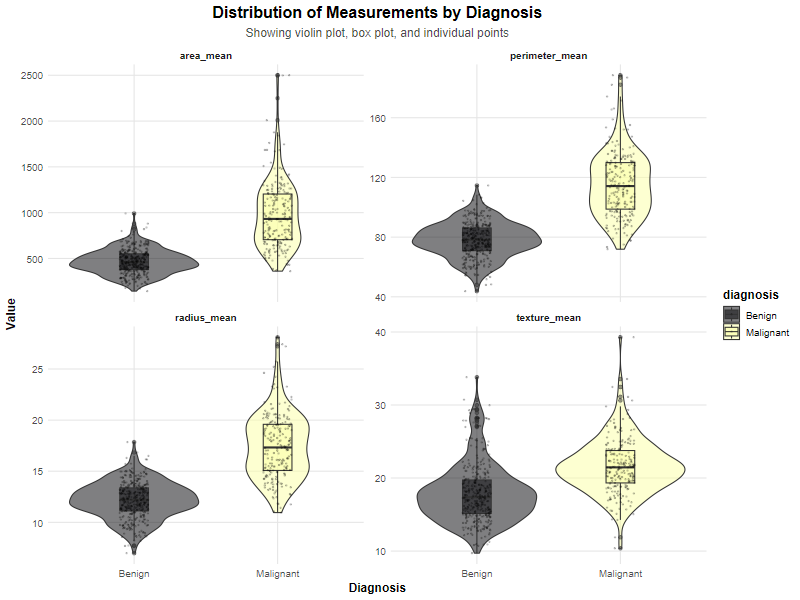

In [14]:
cancer_data %>%
  pivot_longer(cols = all_of(selected_features),
               names_to = "measurement",
               values_to = "value") %>%
  ggplot(aes(diagnosis, value, fill = diagnosis)) +
  geom_violin(alpha = 0.5) +
  geom_boxplot(width = 0.2, alpha = 0.5) +
  geom_jitter(alpha = 0.2, width = 0.1, size = 0.5) +
  facet_wrap(~measurement, scales = "free_y",
            labeller = labeller(measurement = label_wrap_gen(10))) +
  scale_fill_viridis_d(option = "B") +
  labs(title = "Distribution of Measurements by Diagnosis",
       subtitle = "Showing violin plot, box plot, and individual points",
       x = "Diagnosis",
       y = "Value") +
  theme_custom() +
  theme(strip.text = element_text(size = 10, face = "bold")) -> p9
ggsave(filename = "../results/Box & Violin Plot of Measurements by Diagnosis.png", plot = p9, width = 8, height = 6, dpi = 300)
p9

## Feature importance and selection

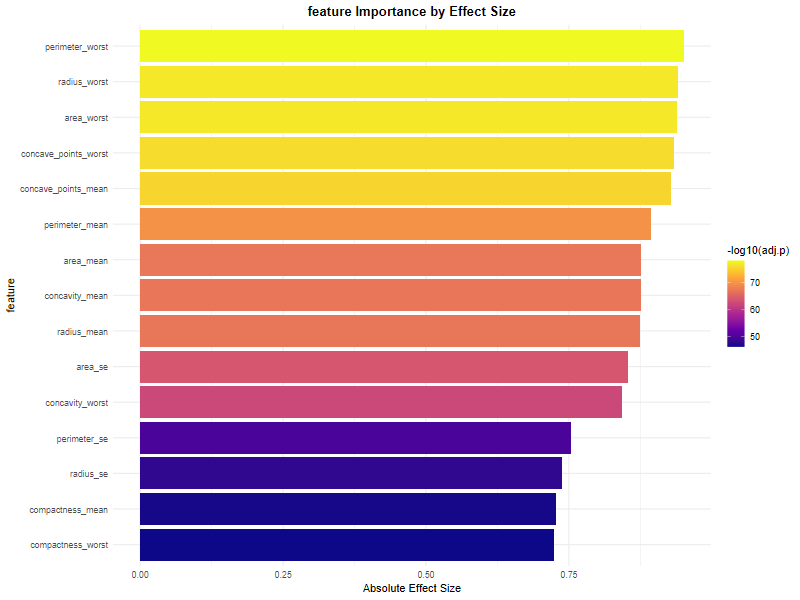

In [15]:
library(effsize)
# Wilcoxon rank-sum test for each feature
feature_importance <- data.frame(
  feature = character(),
  p_value = numeric(),
  effect_size = numeric(),
  stringsAsFactors = FALSE
)

numeric_features <- names(cancer_data)[names(cancer_data) != "diagnosis"]

for (feature in numeric_features) {
  # Wilcoxon test
  test_result <- wilcox.test(cancer_data[[feature]] ~ cancer_data$diagnosis)
  
  # Calculate effect size (Cliff’s delta)
  cliff_delta <- cliff.delta(cancer_data[[feature]], cancer_data$diagnosis)
  
  # Store results
feature_importance <- rbind(feature_importance, 
                             data.frame(feature = feature,
                                        p_value = test_result$p.value,
                                        effect_size = cliff_delta$estimate))
}

# Adjust p-values for multiple testing
feature_importance$p_adjusted <- p.adjust(feature_importance$p_value, method = "BH")

# Sort by effect size
feature_importance <- feature_importance %>%
  arrange(p_adjusted, desc(abs(effect_size)))

# Display top features
feature_importance %>%
  head(15) %>%
  mutate(p_value = format(p_value, scientific = TRUE, digits = 3),
         p_adjusted = format(p_adjusted, scientific = TRUE, digits = 3),
         effect_size = round(effect_size, 3)) %>%
  kable(caption = "top features by Statistical Significance and Effect Size") %>%
  scroll_box(width = "500px", height = "200px")-> feature_importance_tbl

# Visualize feature importance
feature_importance %>%
  head(15) %>%
  mutate(feature = reorder(feature, abs(effect_size))) %>%
  ggplot(aes(x = abs(effect_size), y = feature, fill = -log10(as.numeric(p_adjusted)))) +
  geom_bar(stat = "identity") +
  theme_minimal() +
  labs(title = "feature Importance by Effect Size",
       x = "Absolute Effect Size", 
       y = "feature",
       fill = "-log10(adj.p)") +
  scale_fill_viridis_c(option = "plasma") +
  theme(plot.title = element_text(hjust = 0.5, face = "bold")) -> p10
ggsave(filename = "../results/Feature Importance by Effect Size.png", plot = p10, width = 8, height = 6, dpi = 300)
p10

<div style="border: 1px solid #ddd; padding: 0px; overflow-y: scroll; height:200px; overflow-x: scroll; width:500px; "><table>
<caption>top features by Statistical Significance and Effect Size</caption>
 <thead>
  <tr>
   <th style="text-align:left;position: sticky; top:0; background-color: #FFFFFF;"> feature </th>
   <th style="text-align:left;position: sticky; top:0; background-color: #FFFFFF;"> p_value </th>
   <th style="text-align:right;position: sticky; top:0; background-color: #FFFFFF;"> effect_size </th>
   <th style="text-align:left;position: sticky; top:0; background-color: #FFFFFF;"> p_adjusted </th>
  </tr>
 </thead>
<tbody>
  <tr>
   <td style="text-align:left;"> perimeter_worst </td>
   <td style="text-align:left;"> 3.29e-80 </td>
   <td style="text-align:right;"> -0.951 </td>
   <td style="text-align:left;"> 9.87e-79 </td>
  </tr>
  <tr>
   <td style="text-align:left;"> radius_worst </td>
   <td style="text-align:left;"> 1.45e-78 </td>
   <td style="text-align:right;"> -0.941 </td>
   <td style="text-align:left;"> 2.18e-77 </td>
  </tr>
  <tr>
   <td style="text-align:left;"> area_worst </td>
   <td style="text-align:left;"> 2.31e-78 </td>
   <td style="text-align:right;"> -0.939 </td>
   <td style="text-align:left;"> 2.31e-77 </td>
  </tr>
  <tr>
   <td style="text-align:left;"> concave_points_worst </td>
   <td style="text-align:left;"> 2.40e-77 </td>
   <td style="text-align:right;"> -0.933 </td>
   <td style="text-align:left;"> 1.80e-76 </td>
  </tr>
  <tr>
   <td style="text-align:left;"> concave_points_mean </td>
   <td style="text-align:left;"> 1.30e-76 </td>
   <td style="text-align:right;"> -0.929 </td>
   <td style="text-align:left;"> 7.79e-76 </td>
  </tr>
  <tr>
   <td style="text-align:left;"> perimeter_mean </td>
   <td style="text-align:left;"> 4.67e-71 </td>
   <td style="text-align:right;"> -0.893 </td>
   <td style="text-align:left;"> 2.34e-70 </td>
  </tr>
  <tr>
   <td style="text-align:left;"> area_mean </td>
   <td style="text-align:left;"> 2.04e-68 </td>
   <td style="text-align:right;"> -0.876 </td>
   <td style="text-align:left;"> 8.75e-68 </td>
  </tr>
  <tr>
   <td style="text-align:left;"> concavity_mean </td>
   <td style="text-align:left;"> 2.87e-68 </td>
   <td style="text-align:right;"> -0.875 </td>
   <td style="text-align:left;"> 1.08e-67 </td>
  </tr>
  <tr>
   <td style="text-align:left;"> radius_mean </td>
   <td style="text-align:left;"> 3.57e-68 </td>
   <td style="text-align:right;"> -0.875 </td>
   <td style="text-align:left;"> 1.19e-67 </td>
  </tr>
  <tr>
   <td style="text-align:left;"> area_se </td>
   <td style="text-align:left;"> 7.33e-65 </td>
   <td style="text-align:right;"> -0.853 </td>
   <td style="text-align:left;"> 2.20e-64 </td>
  </tr>
  <tr>
   <td style="text-align:left;"> concavity_worst </td>
   <td style="text-align:left;"> 2.37e-63 </td>
   <td style="text-align:right;"> -0.842 </td>
   <td style="text-align:left;"> 6.47e-63 </td>
  </tr>
  <tr>
   <td style="text-align:left;"> perimeter_se </td>
   <td style="text-align:left;"> 4.90e-51 </td>
   <td style="text-align:right;"> -0.753 </td>
   <td style="text-align:left;"> 1.23e-50 </td>
  </tr>
  <tr>
   <td style="text-align:left;"> radius_se </td>
   <td style="text-align:left;"> 5.82e-49 </td>
   <td style="text-align:right;"> -0.737 </td>
   <td style="text-align:left;"> 1.34e-48 </td>
  </tr>
  <tr>
   <td style="text-align:left;"> compactness_mean </td>
   <td style="text-align:left;"> 1.25e-47 </td>
   <td style="text-align:right;"> -0.727 </td>
   <td style="text-align:left;"> 2.68e-47 </td>
  </tr>
  <tr>
   <td style="text-align:left;"> compactness_worst </td>
   <td style="text-align:left;"> 2.93e-47 </td>
   <td style="text-align:right;"> -0.724 </td>
   <td style="text-align:left;"> 5.86e-47 </td>
  </tr>
</tbody>
</table></div>

**Insights**
1. Top Features:

    Perimeter_worst, radius_worst, and area_worst have the highest effect sizes, indicating that the worst-case measurements of tumor size are the strongest predictors.
    Concave_points_worst and concave_points_mean are also highly influential, suggesting that shape-related features play a critical role in classification.

2. Mid-Tier Features:

    Perimeter_mean, area_mean, and concavity_mean contribute significantly, but their impact is slightly lower than worst-case measurements.

3. Lower Impact Features:

    Compactness_mean and compactness_worst show the least importance, suggesting they contribute less to distinguishing between benign and malignant cases.

## Statistical tests and Analysis


### Mann-Whitney U tests (Wilcoxon Rank-Sum tests)

Let’s formally test the differences between benign and malignant groups for key features.


In [16]:
# select top 8 features based on effect size
top_features <- feature_importance$feature[1:8]

# Create a table of test results
test_results <- data.frame(
  feature = character(),
  benign_median = numeric(),
  malignant_median = numeric(),
  w_statistic = numeric(),
  p_value = numeric(),
  adj_p_value = numeric(),
  effect_size = numeric(),
  stringsAsFactors = FALSE
)

for (feature in top_features) {
  # Extract cancer_data for each group
  benign_values <- cancer_data[cancer_data$diagnosis == "Benign", feature][[1]]
  malignant_values <- cancer_data[cancer_data$diagnosis == "Malignant", feature][[1]]
  
  # Perform Wilcoxon rank-sum test
  test <- wilcox.test(benign_values, malignant_values)
  
  # Calculate effect size
  cliff <- cliff.delta(cancer_data[[feature]], cancer_data$diagnosis)
  
  # Store results
  test_results <- rbind(test_results,
                       data.frame(feature = feature,
                                  benign_median = median(benign_values),
                                  malignant_median = median(malignant_values),
                                  w_statistic = test$statistic,
                                  p_value = test$p.value,
                                  adj_p_value = NA,  # Will adjust later
                                  effect_size = cliff$estimate))
}

# Adjust p-values for multiple testing
test_results$adj_p_value <- p.adjust(test_results$p_value, method = "BH")

test_results %>%
  mutate(
    feature = gsub("_", " ", feature),
    benign_median = round(benign_median, 3),
    malignant_media = round(malignant_median, 3),
    w_statistic = round(w_statistic, 1),
    p_value = format(p_value, scientific = TRUE, digits = 3),
    adj_p_value = format(adj_p_value, scientific = TRUE, digits = 3),
    effect_size = round(effect_size, 3)) -> test_results_formatted

# Display table
test_results_formatted %>%
  kable(caption = "Mann-Whitney U test Results for top features") %>%
  kable_styling(bootstrap_options = c("striped", "hover")) -> test_results_formatted

<table class="table table-striped table-hover" style="margin-left: auto; margin-right: auto;">
<caption>Mann-Whitney U test Results for top features</caption>
 <thead>
  <tr>
   <th style="text-align:left;">  </th>
   <th style="text-align:left;"> feature </th>
   <th style="text-align:right;"> benign_median </th>
   <th style="text-align:right;"> malignant_median </th>
   <th style="text-align:right;"> w_statistic </th>
   <th style="text-align:left;"> p_value </th>
   <th style="text-align:left;"> adj_p_value </th>
   <th style="text-align:right;"> effect_size </th>
   <th style="text-align:right;"> malignant_media </th>
  </tr>
 </thead>
<tbody>
  <tr>
   <td style="text-align:left;"> W </td>
   <td style="text-align:left;"> perimeter worst </td>
   <td style="text-align:right;"> 86.945 </td>
   <td style="text-align:right;"> 138.00000 </td>
   <td style="text-align:right;"> 1858.0 </td>
   <td style="text-align:left;"> 3.29e-80 </td>
   <td style="text-align:left;"> 2.63e-79 </td>
   <td style="text-align:right;"> -0.951 </td>
   <td style="text-align:right;"> 138.000 </td>
  </tr>
  <tr>
   <td style="text-align:left;"> W1 </td>
   <td style="text-align:left;"> radius worst </td>
   <td style="text-align:right;"> 13.350 </td>
   <td style="text-align:right;"> 20.59000 </td>
   <td style="text-align:right;"> 2237.0 </td>
   <td style="text-align:left;"> 1.45e-78 </td>
   <td style="text-align:left;"> 5.82e-78 </td>
   <td style="text-align:right;"> -0.941 </td>
   <td style="text-align:right;"> 20.590 </td>
  </tr>
  <tr>
   <td style="text-align:left;"> W2 </td>
   <td style="text-align:left;"> area worst </td>
   <td style="text-align:right;"> 547.600 </td>
   <td style="text-align:right;"> 1303.00000 </td>
   <td style="text-align:right;"> 2283.5 </td>
   <td style="text-align:left;"> 2.31e-78 </td>
   <td style="text-align:left;"> 6.17e-78 </td>
   <td style="text-align:right;"> -0.939 </td>
   <td style="text-align:right;"> 1303.000 </td>
  </tr>
  <tr>
   <td style="text-align:left;"> W3 </td>
   <td style="text-align:left;"> concave points worst </td>
   <td style="text-align:right;"> 0.074 </td>
   <td style="text-align:right;"> 0.18200 </td>
   <td style="text-align:right;"> 2520.0 </td>
   <td style="text-align:left;"> 2.40e-77 </td>
   <td style="text-align:left;"> 4.80e-77 </td>
   <td style="text-align:right;"> -0.933 </td>
   <td style="text-align:right;"> 0.182 </td>
  </tr>
  <tr>
   <td style="text-align:left;"> W4 </td>
   <td style="text-align:left;"> concave points mean </td>
   <td style="text-align:right;"> 0.024 </td>
   <td style="text-align:right;"> 0.08628 </td>
   <td style="text-align:right;"> 2691.5 </td>
   <td style="text-align:left;"> 1.30e-76 </td>
   <td style="text-align:left;"> 2.08e-76 </td>
   <td style="text-align:right;"> -0.929 </td>
   <td style="text-align:right;"> 0.086 </td>
  </tr>
  <tr>
   <td style="text-align:left;"> W5 </td>
   <td style="text-align:left;"> perimeter mean </td>
   <td style="text-align:right;"> 78.225 </td>
   <td style="text-align:right;"> 114.20000 </td>
   <td style="text-align:right;"> 4019.0 </td>
   <td style="text-align:left;"> 4.67e-71 </td>
   <td style="text-align:left;"> 6.23e-71 </td>
   <td style="text-align:right;"> -0.893 </td>
   <td style="text-align:right;"> 114.200 </td>
  </tr>
  <tr>
   <td style="text-align:left;"> W6 </td>
   <td style="text-align:left;"> area mean </td>
   <td style="text-align:right;"> 458.550 </td>
   <td style="text-align:right;"> 932.00000 </td>
   <td style="text-align:right;"> 4668.5 </td>
   <td style="text-align:left;"> 2.04e-68 </td>
   <td style="text-align:left;"> 2.33e-68 </td>
   <td style="text-align:right;"> -0.876 </td>
   <td style="text-align:right;"> 932.000 </td>
  </tr>
  <tr>
   <td style="text-align:left;"> W7 </td>
   <td style="text-align:left;"> concavity mean </td>
   <td style="text-align:right;"> 0.037 </td>
   <td style="text-align:right;"> 0.15135 </td>
   <td style="text-align:right;"> 4705.5 </td>
   <td style="text-align:left;"> 2.87e-68 </td>
   <td style="text-align:left;"> 2.87e-68 </td>
   <td style="text-align:right;"> -0.875 </td>
   <td style="text-align:right;"> 0.151 </td>
  </tr>
</tbody>
</table>

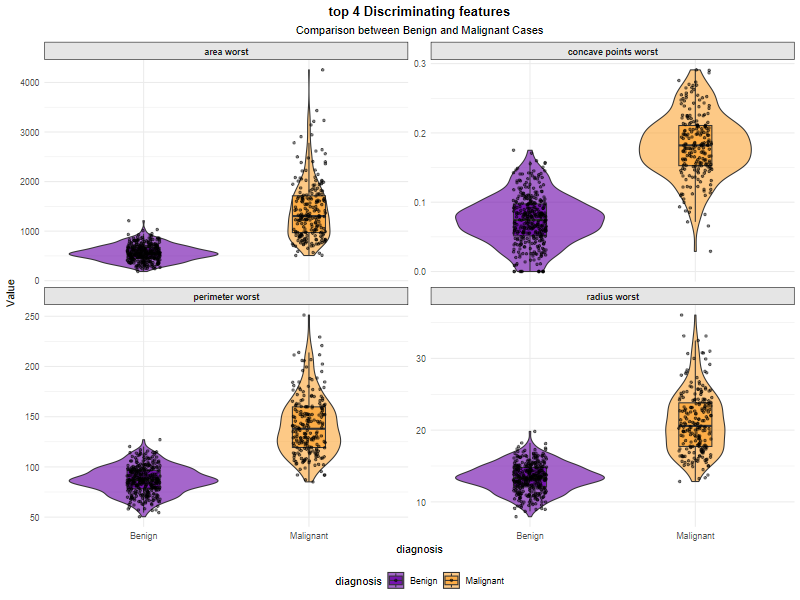

In [17]:
options(repr.plot.height = 12, repr.plot.width = 12)
# select top 4 features for visualization
top4_features <- feature_importance$feature[1:4]

# Reshape data for visualization
top4_long <- cancer_data %>%
  select(diagnosis, all_of(top4_features)) %>%
  pivot_longer(cols = -diagnosis, 
               names_to = "feature", 
               values_to = "Value")

# Clean feature names for visualization
top4_long$feature <- gsub("_", " ", top4_long$feature)

# Create violin plots with box plots and individual points
ggplot(top4_long, aes(x = diagnosis, y = Value, fill = diagnosis)) +
  geom_violin(alpha = 0.6) +
  geom_boxplot(width = 0.2, alpha = 0.8, outlier.shape = NA) +
  geom_jitter(width = 0.1, alpha = 0.5, size = 1) +
  facet_wrap(~ feature, scales = "free_y", ncol = 2) +
  theme_minimal() +
  labs(title = "top 4 Discriminating features",
       subtitle = "Comparison between Benign and Malignant Cases",
       X = "", y = "Value") +
  scale_fill_viridis_d(option = "plasma", begin = 0.2, end = 0.8) +
  theme(legend.position = "bottom",
        plot.title = element_text(hjust = 0.5, face = "bold"),
        plot.subtitle = element_text(hjust = 0.5),
        strip.background = element_rect(fill = "gray90"),
        strip.text = element_text(face = "bold")) -> discriminating_features
ggsave(filename = "../results/Discriminating Features.png", plot = discriminating_features, width = 8, height = 6, dpi = 300)
discriminating_features

**Insights**
1. Area Worst & Perimeter Worst

    - Malignant tumors tend to have significantly larger worst-case areas and perimeters than benign ones.
    - The spread in malignant cases is much wider, indicating greater variability.

2. Concave Points Worst

    - Malignant cases exhibit more concave points, suggesting more irregular tumor shapes.
    - Benign tumors have a more compact and lower distribution of concave points.

3. Radius Worst

    - Malignant tumors generally have a larger worst-case radius than benign ones.
    - The distribution for malignant cases is more spread out.

## Hypothesis Tests and Effect Sizes

### Hypothesis 1: Malignant tumors have significantly different mean radius compared to benign tumors

$H_o$: No difference in radius_mean between malignant and benign tumors

$H_1$: There is a significant difference in radius_mean between tumor types

In [18]:
library(effectsize)

radius_test <- function(data) {
  # Test for normality
  shapiro_test_m <- shapiro.test(data$radius_mean[data$diagnosis == "Malignant"])
  shapiro_test_b <- shapiro.test(data$radius_mean[data$diagnosis == "Benign"])
  
  # If normal, use t-test; if not, use Mann-Whitney
  if (shapiro_test_m$p.value > 0.05 && shapiro_test_b$p.value > 0.05) {
    test_result <- t.test(radius_mean ~ diagnosis, data = data)
    effect <- cohens_d(radius_mean ~ diagnosis, data = data)
  } else {
    test_result <- wilcox.test(radius_mean ~ diagnosis, data = data)
    effect <- rank_biserial(radius_mean ~ diagnosis, data = data)
  }
  
  list(test = test_result, effect_size = effect)
}

radius_test(cancer_data)

$test

	Wilcoxon rank sum test with continuity correction

data:  radius_mean by diagnosis
W = 4729, p-value < 2.2e-16
alternative hypothesis: true location shift is not equal to 0


$effect_size
r (rank biserial) |         95% CI
----------------------------------
-0.87             | [-0.90, -0.85]



### Hypothesis 2: There are significant differences in cell characteristics across multiple features¶

MANOVA test for multiple dependent variables


In [19]:
manova_test <- function(data) {
  dependent_vars <- data %>% 
    select(radius_mean, texture_mean, perimeter_mean, area_mean)
  
  manova_result <- manova(as.matrix(dependent_vars) ~ diagnosis, data = data)
  summary(manova_result)
}

manova_test(cancer_data)

           Df Pillai approx F num Df den Df    Pr(>F)    
diagnosis   1 0.6182    227.9      4    563 < 2.2e-16 ***
Residuals 566                                            
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

In [20]:
library(dendextend)
# Hierarchical feature clustering

feature_dist <- dist(t(scale(cancer_data %>% 
  select(-diagnosis))))
feature_hclust <- hclust(feature_dist, method = "ward.D2")
feature_dend <- as.dendrogram(feature_hclust)
feature_dend <- color_branches(feature_dend, k = 5)
png("../results/hierarchical_clustering.png", width = 8, height = 6, units = "in", res = 300)
plot(feature_dend, main = "Hierarchical clustering of Cancer Dataset Features")
dev.off()



---------------------
Welcome to dendextend version 1.19.0
Type citation('dendextend') for how to cite the package.

Type browseVignettes(package = 'dendextend') for the package vignette.
The github page is: https://github.com/talgalili/dendextend/

Suggestions and bug-reports can be submitted at: https://github.com/talgalili/dendextend/issues
You may ask questions at stackoverflow, use the r and dendextend tags: 
	 https://stackoverflow.com/questions/tagged/dendextend

	To suppress this message use:  suppressPackageStartupMessages(library(dendextend))
---------------------


Attaching package: ‘dendextend’

The following object is masked from ‘package:ggpubr’:

    rotate

The following object is masked from ‘package:dials’:

    prune

The following object is masked from ‘package:stats’:

    cutree



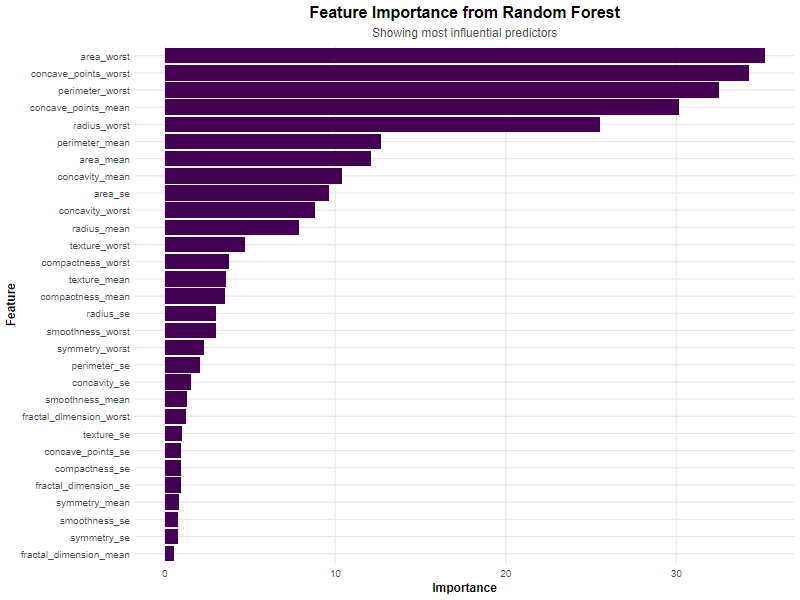

In [21]:
## Feature Importance plot
rf_recipe <- recipe(diagnosis ~ ., data = cancer_data) %>%
  step_normalize(all_predictors())

rf_model <- rand_forest() %>%
  set_engine("ranger", importance = "impurity") %>%
  set_mode("classification")

rf_wflow <- workflow() %>%
  add_recipe(rf_recipe) %>%
  add_model(rf_model)

rf_fit <- rf_wflow %>%
  fit(data = cancer_data)

rf_fit %>%
 extract_fit_parsnip() %>%
 vi() %>%
 mutate(Variable = fct_reorder(Variable, Importance)) -> importance_data

ggplot(importance_data, aes(Importance, Variable)) +
  geom_bar(stat = "identity", fill = viridis(1)) +
  labs(title = "Feature Importance from Random Forest",
       subtitle = "Showing most influential predictors",
       x = "Importance",
       y = "Feature") +
  theme_custom() -> importance_plot
ggsave(filename = "../results/Feature Importance From Random Forest.png", plot = importance_plot, width = 8, height = 6, dpi = 300)
importance_plot

1. Top Predictors

    - area_worst, concave_points_worst, and perimeter_worst are the most critical features.
    - These features relate to tumor size and shape irregularities, which are strong indicators of malignancy.

2. Mean vs. Worst-Case Features

    - Worst-case measurements (e.g., area_worst, perimeter_worst) have higher importance than mean values.
    - This suggests that extreme values in tumor characteristics provide better discrimination power.

3. Less Influential Features

    - Features like fractal_dimension_mean, symmetry_se, and smoothness_se contribute little to the classification.
    - These could be considered for feature selection or dimensionality reduction.

This plot confirms that size, shape, and concavity features play a significant role in breast cancer classification using Random Forest.

## Predictive Modelling

In [22]:
# Prepare data for modeling
set.seed(123)
splits <- initial_split(cancer_data, prop = 0.75, strata = diagnosis)
training <- training(splits)
testing <- testing(splits)

# Check class distribution in training and testing sets
train_distribution <- table(training$diagnosis)
test_distribution <- table(testing$diagnosis)

cv_folds <- vfold_cv(training, v = 10, strata = diagnosis)
train_distribution_df <- as.data.frame(train_distribution)
colnames(train_distribution_df) <- c("diagnosis", "count")
train_distribution_df$Percentage <- train_distribution_df$count / sum(train_distribution_df$count) * 100

test_distribution_df <- as.data.frame(test_distribution)
colnames(test_distribution_df) <- c("diagnosis", "count")
test_distribution_df$Percentage <- test_distribution_df$count / sum(test_distribution_df$count) * 100

# Display class distribution
cat("training Set Distribution:\n")
train_distribution_df %>%
  kable() %>% 
  print()

cat("\ntesting Set Distribution:\n")
test_distribution_df %>%
  kable() %>% 
  print()

training Set Distribution:


|diagnosis | count| Percentage|
|:---------|-----:|----------:|
|Benign    |   267|   62.67606|
|Malignant |   159|   37.32394|

testing Set Distribution:


|diagnosis | count| Percentage|
|:---------|-----:|----------:|
|Benign    |    89|   62.67606|
|Malignant |    53|   37.32394|


## Logistic Regression model

In [23]:
library(car)
logistic_reg_glm_spec <-
  logistic_reg() %>%
  set_engine('glm')

# select features for the model based on our analysis
# Use top features and avoid highly correlated ones
model_features <- c("concavity_mean", "concave_points_mean", "perimeter_mean", 
                   "texture_mean", "smoothness_mean", "symmetry_mean")

# Formula for the model
formula <- as.formula(paste("diagnosis ~", paste(model_features, collapse = " + ")))

log_reg_fit <- logistic_reg_glm_spec %>% 
  fit(formula, data = training)
# Fit logistic regression model
#logistic_model <- glm(formula, data = training, family = "binomial")

# Model summary
summary(log_reg_fit$fit)

# Check for multicollinearity
vif_values <- vif(log_reg_fit$fit)
vif_df <- data.frame(
  feature = names(vif_values),
  Vif = vif_values
)

# Display Vif values
vif_df %>%
  arrange(desc(Vif)) %>%
  kable(caption = "Variance Inflation Factors (Vif) for Model features") %>%
  kable_styling(bootstrap_options = c("striped", "hover")) -> vif_df



Loading required package: carData

Attaching package: ‘car’

The following object is masked from ‘package:dplyr’:

    recode

The following object is masked from ‘package:purrr’:

    some



In [24]:
# Check for multicollinearity
vif_values <- vif(log_reg_fit$fit)
vif_df <- data.frame(
  feature = names(vif_values),
  Vif = vif_values
)

# Display Vif values
vif_df %>%
  arrange(desc(Vif)) %>%
  kable(caption = "Variance Inflation Factors (Vif) for Model features") %>%
  kable_styling(bootstrap_options = c("striped", "hover")) -> vif_df

<table class="table table-striped table-hover" style="margin-left: auto; margin-right: auto;">
<caption>Variance Inflation Factors (Vif) for Model features</caption>
 <thead>
  <tr>
   <th style="text-align:left;">  </th>
   <th style="text-align:left;"> feature </th>
   <th style="text-align:right;"> Vif </th>
  </tr>
 </thead>
<tbody>
  <tr>
   <td style="text-align:left;"> concave_points_mean </td>
   <td style="text-align:left;"> concave_points_mean </td>
   <td style="text-align:right;"> 5.831716 </td>
  </tr>
  <tr>
   <td style="text-align:left;"> smoothness_mean </td>
   <td style="text-align:left;"> smoothness_mean </td>
   <td style="text-align:right;"> 4.407593 </td>
  </tr>
  <tr>
   <td style="text-align:left;"> concavity_mean </td>
   <td style="text-align:left;"> concavity_mean </td>
   <td style="text-align:right;"> 3.363412 </td>
  </tr>
  <tr>
   <td style="text-align:left;"> perimeter_mean </td>
   <td style="text-align:left;"> perimeter_mean </td>
   <td style="text-align:right;"> 2.752074 </td>
  </tr>
  <tr>
   <td style="text-align:left;"> symmetry_mean </td>
   <td style="text-align:left;"> symmetry_mean </td>
   <td style="text-align:right;"> 2.126114 </td>
  </tr>
  <tr>
   <td style="text-align:left;"> texture_mean </td>
   <td style="text-align:left;"> texture_mean </td>
   <td style="text-align:right;"> 1.948744 </td>
  </tr>
</tbody>
</table>

### Model Evaluation

In [25]:
library(pROC)
# Make predictions on test set
predictions <- predict(log_reg_fit, new_data = testing) %>% 
  bind_cols(testing)
probabilities <- predict(log_reg_fit, testing, type = "prob") %>% 
  bind_cols(testing)
# Confusion matrix
conf_matrix <- conf_mat(predictions, truth = diagnosis, estimate= .pred_class)
conf_matrix

calculate_metrics <- function(pred_df, truth_col, pred_col) {
  # Convert column names to symbols
  truth_sym <- sym(truth_col)
  pred_sym <- sym(pred_col)
  
  # Ensure the columns are factors with the same levels
  pred_df <- pred_df %>%
    mutate(
      !!truth_col := factor(!!truth_sym),
      !!pred_col := factor(!!pred_sym)
    )
  
  # Calculate metrics one by one to avoid errors
  acc <- pred_df %>% accuracy(truth = !!truth_sym, estimate = !!pred_sym)
  sens <- pred_df %>% sensitivity(truth = !!truth_sym, estimate = !!pred_sym, event_level = "second")
  spec <- pred_df %>% specificity(truth = !!truth_sym, estimate = !!pred_sym, event_level = "second")
  ppv_val <- pred_df %>% ppv(truth = !!truth_sym, estimate = !!pred_sym, event_level = "second")
  npv_val <- pred_df %>% npv(truth = !!truth_sym, estimate = !!pred_sym, event_level = "second")
  f1 <- pred_df %>% f_meas(truth = !!truth_sym, estimate = !!pred_sym, event_level = "second")
  
  # Combine all metrics
  bind_rows(
    acc,
    sens,
    spec,
    ppv_val,
    npv_val,
    f1
  )
}

metrics_table <- calculate_metrics(
   pred_df = predictions,
   truth_col = "diagnosis", 
   pred_col = ".pred_class"
 ) %>% 
  select(.metric, .estimate) %>% 
  rename(metric = .metric, value = .estimate)

# Display metrics
metrics_table %>%
  mutate(value = round(value, 4)) %>%
  kable(caption = "Model Performance Metrics")


roc_obj <- roc(testing$diagnosis, probabilities$.pred_Malignant)
auc_value <- auc(roc_obj)
# plot ROC curve
ggroc(roc_obj, colour = "#440154", size = 1.5) +
  geom_abline(intercept = 1, slope = 1, linetype = "dashed", color = "gray40") +
  annotate("text", x = 0.75, y = 0.25, 
           label = paste("AUC =", round(auc_value, 3)), 
           size = 5, color = "#440154") +
  theme_minimal() +
  labs(title = "ROC Curve for Logistic Regression Model",
       x = "False Positive Rate (1 – Specificity)",  
       y = "True Positive Rate (Sensitivity)") +  
  theme(plot.title = element_text(hjust = 0.5, face = "bold"))

ggsave(filename = "../results/ROC_Curve_Logistic_Regression.png", width = 8, height = 6, dpi = 300)


Type 'citation("pROC")' for a citation.

Attaching package: ‘pROC’

The following objects are masked from ‘package:stats’:

    cov, smooth, var

Setting levels: control = Benign, case = Malignant
Setting direction: controls < cases


### Feature Importance in model

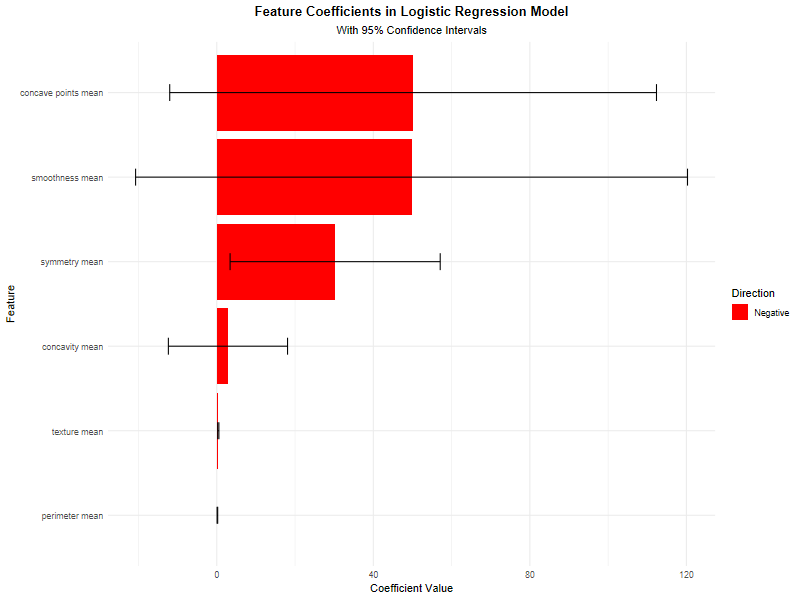

In [26]:
# Extract coefficients
coefs <- tidy(log_reg_fit)
coef_df <- data.frame(
  feature = coefs$term,
  coefficient = coefs$estimate,
  std_Error = coefs$std.error,
  z_value = coefs$statistic,
  p_value = coefs$p.value
)

# Remove intercept
coef_df <- coef_df[-1, ]

# Calculate odds ratios
coef_df <- coef_df %>%
  mutate(
    Odds_Ratio = exp(coefficient),
    OR_Lower_CI = exp(coefficient - 1.96 * std_Error),
    OR_Upper_CI = exp(coefficient + 1.96 * std_Error),
    Significance = case_when(
      p_value < 0.001 ~ "***",
      p_value < 0.01  ~ "**",
      p_value < 0.05  ~ "*",
      TRUE            ~ ""
    )
  )

# Format feature names
coef_df$feature <- gsub("_", " ", coef_df$feature)

# Order by absolute coefficient value
coef_df <- coef_df %>% arrange(desc(abs(coefficient)))

# Create formatted table
coef_table <- coef_df %>%
  mutate(
    Odds_Ratio = round(Odds_Ratio, 3),
    OR_Lower_CI = round(OR_Lower_CI, 3),
    OR_Upper_CI = round(OR_Upper_CI, 3),
    P_value = format(p_value, scientific = TRUE, digits = 3),
    `95% CI` = paste0("(", OR_Lower_CI, " – ", OR_Upper_CI, ")")
  ) %>%
  select(feature, Odds_Ratio, '95% CI', p_value, Significance) %>%
  kable(caption = "Odds Ratios for Model Features") %>%
  kable_styling(bootstrap_options = c("striped", "hover"))

# Visualize coefficients
ggplot(coef_df, aes(x = coefficient, y = reorder(feature, abs(coefficient)), fill = coefficient > 0)) +
  geom_bar(stat = "identity") +
  geom_errorbarh(aes(xmin = coefficient - 1.96 * std_Error, 
                     xmax = coefficient + 1.96 * std_Error), 
                 height = 0.2) +
  theme_minimal() +
  labs(title = "Feature Coefficients in Logistic Regression Model",
       subtitle = "With 95% Confidence Intervals",
       x = "Coefficient Value", 
       y = "Feature") +
  scale_fill_manual(values = c("red", "blue"), 
                    name = "Direction", 
                    labels = c("Negative", "Positive")) +
  theme(plot.title = element_text(hjust = 0.5, face = "bold"),
        plot.subtitle = element_text(hjust = 0.5)) -> feature_coefs_plot
        ggsave(filename = "../results/Feature Coefficient Plot.png", plot = feature_coefs_plot, width = 8, height = 6, dpi = 300)
feature_coefs_plot

<table class="table table-striped table-hover" style="margin-left: auto; margin-right: auto;">
<caption>Odds Ratios for Model Features</caption>
 <thead>
  <tr>
   <th style="text-align:left;"> feature </th>
   <th style="text-align:right;"> Odds_Ratio </th>
   <th style="text-align:left;"> 95% CI </th>
   <th style="text-align:right;"> p_value </th>
   <th style="text-align:left;"> Significance </th>
  </tr>
 </thead>
<tbody>
  <tr>
   <td style="text-align:left;"> concave points mean </td>
   <td style="text-align:right;"> 6.122968e+21 </td>
   <td style="text-align:left;"> (0 – 6.26583290229668e+48) </td>
   <td style="text-align:right;"> 0.1138813 </td>
   <td style="text-align:left;">  </td>
  </tr>
  <tr>
   <td style="text-align:left;"> smoothness mean </td>
   <td style="text-align:right;"> 4.124302e+21 </td>
   <td style="text-align:left;"> (0 – 1.73917752928599e+52) </td>
   <td style="text-align:right;"> 0.1665475 </td>
   <td style="text-align:left;">  </td>
  </tr>
  <tr>
   <td style="text-align:left;"> symmetry mean </td>
   <td style="text-align:right;"> 1.368952e+13 </td>
   <td style="text-align:left;"> (30.014 – 6.24385098633511e+24) </td>
   <td style="text-align:right;"> 0.0272197 </td>
   <td style="text-align:left;"> * </td>
  </tr>
  <tr>
   <td style="text-align:left;"> concavity mean </td>
   <td style="text-align:right;"> 1.739600e+01 </td>
   <td style="text-align:left;"> (0 – 71380948.654) </td>
   <td style="text-align:right;"> 0.7131359 </td>
   <td style="text-align:left;">  </td>
  </tr>
  <tr>
   <td style="text-align:left;"> texture mean </td>
   <td style="text-align:right;"> 1.470000e+00 </td>
   <td style="text-align:left;"> (1.264 – 1.708) </td>
   <td style="text-align:right;"> 0.0000005 </td>
   <td style="text-align:left;"> *** </td>
  </tr>
  <tr>
   <td style="text-align:left;"> perimeter mean </td>
   <td style="text-align:right;"> 1.170000e+00 </td>
   <td style="text-align:left;"> (1.084 – 1.263) </td>
   <td style="text-align:right;"> 0.0000574 </td>
   <td style="text-align:left;"> *** </td>
  </tr>
</tbody>
</table>

# Modelling with PCA

In [27]:
features <- cancer_data %>%
 select(-diagnosis)

target <- cancer_data$diagnosis

In [28]:
# Perform PCA
pca_result <- prcomp(features, scale. = TRUE)
summarize_pca <- function(pca_obj){
  # Calculate variance explained
  var_explained <- pca_obj$sdev^2 / sum(pca_obj$sdev^2)
  cum_var_explained <- cumsum(var_explained)

  # Create summary dataframe
  pca_summary <- data.frame(
    PC = paste0("PC", 1:length(var_explained)),
    var_explained = var_explained,
    cum_var_explained = cum_var_explained)
  
  return(pca_summary)
}

pca_summary <- summarize_pca(pca_result)

# Plot Scree Plot
plot_scree <- function(pca_summary){
  ggplot(pca_summary, aes(PC)) +
    geom_line(aes(y = var_explained), fill = viridis(1)) +
    geom_col(aes(y = cum_var_explained, group = 1), color = "red") +
    geom_point(aes(y = cum_var_explained), color = "red") +
    scale_y_continuous(
      name = "Proportion of Variance Explained",
      sec.axis = sec_axis(~., name = "Cumulative Proportion")
    ) +
    labs(title = "Scree Plot with Cumulative Variance",
          x = "Principal Component") +
    theme_custom() +
    theme(axis.text.x = element_text(angle = 45))
}

plot_pca_biplot <- function(pca_obj, data, target) {
  # Get PC scores
  scores <- as.data.frame(pca_obj$x)
  scores$diagnosis <- target
  
  # Create biplot
  ggplot(scores, aes(x = PC1, y = PC2, color = diagnosis)) +
    geom_point(alpha = 0.6) +
    stat_ellipse(level = 0.95) +
    scale_color_viridis_d() +
    labs(title = "PCA Biplot",
         x = paste0("PC1 (", round(pca_summary$var_explained[1] * 100, 1), "%)"),
         y = paste0("PC2 (", round(pca_summary$var_explained[2] * 100, 1), "%)")) +
    theme_minimal()
}

# Calculate feature contributions
feature_contributions <- as.data.frame(abs(pca_result$rotation)) %>%
  mutate(feature = rownames(.)) %>%
  pivot_longer(-feature, names_to = "PC", values_to = "contribution")

# Plot feature contributions
plot_feature_contributions <- function(feature_contributions) {
  feature_contributions %>%
    filter(PC %in% c("PC1", "PC2", "PC3")) %>%
    ggplot(aes(x = reorder(feature, contribution), y = contribution, fill = PC)) +
    geom_col(position = "dodge") +
    coord_flip() +
    scale_fill_viridis_d() +
    labs(title = "Feature Contributions to Principal Components",
         x = "Feature",
         y = "Absolute Contribution") +
    theme_minimal()
}

In [29]:
ggsave(filename = "../results/PCA Summary.png", plot = plot_scree(pca_summary), width = 8, height = 6, dpi = 300)
ggsave(filename = "../results/feature_contributions.png", plot = plot_feature_contributions(feature_contributions), width = 8, height = 6, dpi = 300)
ggsave(filename = "../results/PCA Biplot.png", plot = plot_pca_biplot(pca_result, cancer_data, cancer_data$diagnosis), width = 8, height = 6, dpi = 300)

`geom_line()`: Each group consists of only one observation.
ℹ Do you need to adjust the group aesthetic?


Warning message:
In geom_line(aes(y = var_explained), fill = viridis(1)) :
  Ignoring unknown parameters: `fill`


Warning message:
In geom_line(aes(y = var_explained), fill = viridis(1)) :
  Ignoring unknown parameters: `fill`


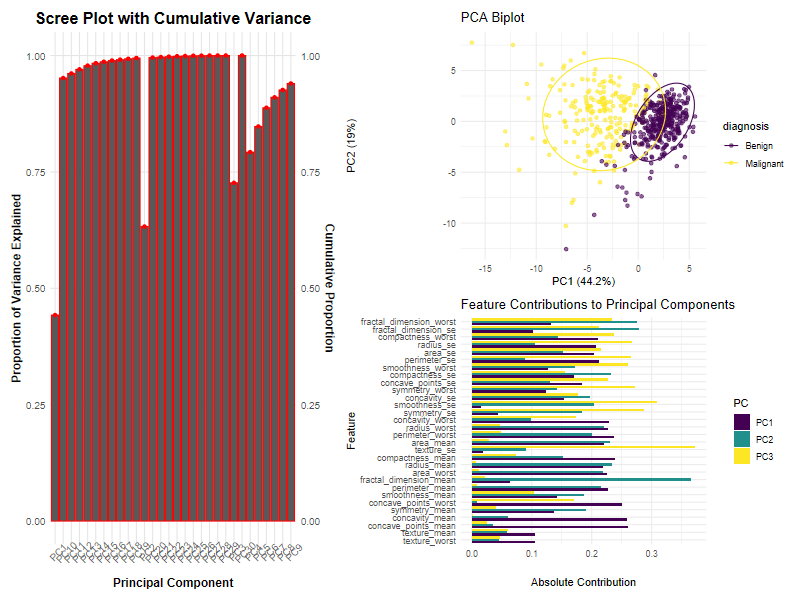

`geom_line()`: Each group consists of only one observation.
ℹ Do you need to adjust the group aesthetic?

In [30]:
plot_scree(pca_summary) + plot_pca_biplot(pca_result, cancer_data, cancer_data$diagnosis) / plot_feature_contributions(feature_contributions)

In [31]:
# Function to perform PCA analysis with Kaiser criterion
analyze_pca_kaiser <- function(data) {
  # Perform PCA
  pca_result <- prcomp(data, scale. = TRUE)
  
  # Calculate eigenvalues
  eigenvalues <- pca_result$sdev^2
  
  # Create Kaiser criterion analysis
  kaiser_analysis <- data.frame(
    Component = paste0("PC", 1:length(eigenvalues)),
    Eigenvalue = eigenvalues,
    Variance_Explained = eigenvalues / sum(eigenvalues),
    Cumulative_Variance = cumsum(eigenvalues / sum(eigenvalues)),
    Meets_Kaiser = eigenvalues > 1
  ) %>%
    mutate(
      Criterion = ifelse(Meets_Kaiser, "Above Kaiser Criterion", "Below Kaiser Criterion")
    )
  
  # Count components meeting Kaiser criterion
  n_components_kaiser <- sum(eigenvalues > 1)
  
  # Create visualization
  kaiser_plot <- ggplot(kaiser_analysis, aes(x = Component, y = Eigenvalue, fill = Criterion)) +
    geom_col() +
    geom_hline(yintercept = 1, linetype = "dashed", color = "red") +
    scale_fill_viridis_d() +
    labs(
      title = "Eigenvalues with Kaiser Criterion",
      subtitle = paste("Components with eigenvalue > 1:", n_components_kaiser),
      x = "Principal Component",
      y = "Eigenvalue"
    ) +
    theme_minimal() +
    theme(
      axis.text.x = element_text(angle = 45, hjust = 1),
      plot.subtitle = element_text(size = 10, color = "darkgray")
    )
  
  # Create variance explained plot
  variance_plot <- ggplot(kaiser_analysis, aes(x = Component)) +
    geom_line(aes(y = Cumulative_Variance, group = 1), color = "blue") +
    geom_point(aes(y = Cumulative_Variance), color = "blue") +
    geom_col(aes(y = Variance_Explained, fill = Criterion), alpha = 0.5) +
    scale_fill_viridis_d() +
    labs(
      title = "Variance Explained by Principal Components",
      x = "Principal Component",
      y = "Proportion of Variance"
    ) +
    theme_minimal() +
    theme(axis.text.x = element_text(angle = 45, hjust = 1))
  
  # Calculate summary statistics
  summary_stats <- list(
    n_components_kaiser = n_components_kaiser,
    variance_explained_kaiser = sum(kaiser_analysis$Variance_Explained[kaiser_analysis$Meets_Kaiser]),
    components_summary = kaiser_analysis
  )
  
  # Return results
  return(list(
    pca_result = pca_result,
    kaiser_analysis = kaiser_analysis,
    kaiser_plot = kaiser_plot,
    variance_plot = variance_plot,
    summary_stats = summary_stats
  ))
}


# Prepare data for PCA (remove ID and target variable)
pca_data <- cancer_data %>%
  select(-diagnosis)

# Perform analysis
pca_analysis <- analyze_pca_kaiser(pca_data)

# Print summary
print("Summary of Kaiser Criterion Analysis:")
print(paste("Number of components suggested by Kaiser criterion:",
            pca_analysis$summary_stats$n_components_kaiser))
print(paste("Cumulative variance explained by Kaiser components:",
            round(pca_analysis$summary_stats$variance_explained_kaiser * 100, 2), "%"))

# Display full component summary
print("\nDetailed Component Analysis:")
print(pca_analysis$kaiser_analysis %>%
        select(Component, Eigenvalue, Variance_Explained, Meets_Kaiser) %>%
        head(pca_analysis$summary_stats$n_components_kaiser))

# Combine plots
combined_plot <- gridExtra::grid.arrange(
  pca_analysis$kaiser_plot,
  pca_analysis$variance_plot,
  ncol = 1
)

# Function to get rotations for Kaiser-selected components
get_kaiser_components <- function(pca_result, kaiser_analysis) {
  n_components <- sum(kaiser_analysis$Meets_Kaiser)
  
  # Get rotation matrix for selected components
  rotations <- pca_result$rotation[, 1:n_components, drop = FALSE]
  
  # Create summary dataframe
  rotation_summary <- as.data.frame(rotations) %>%
    mutate(Feature = rownames(.)) %>%
    pivot_longer(
      cols = -Feature,
      names_to = "Component",
      values_to = "Loading"
    ) %>%
    arrange(Component, desc(abs(Loading)))
  
  return(rotation_summary)
}

# Get loadings for Kaiser components
kaiser_loadings <- get_kaiser_components(pca_analysis$pca_result, 
                                       pca_analysis$kaiser_analysis)

# Create loadings plot
loadings_plot <- kaiser_loadings %>%
  ggplot(aes(x = reorder(Feature, abs(Loading)), y = Loading, fill = Loading)) +
  geom_col() +
  facet_wrap(~Component) +
  scale_fill_viridis() +
  theme_minimal() +
  theme(axis.text.x = element_text(angle = 45, hjust = 1)) +
  labs(
    title = "Feature Loadings for Kaiser-Selected Components",
    x = "Feature",
    y = "Loading"
  )

# Return results as a list
results <- list(
  analysis = pca_analysis,
  loadings = kaiser_loadings,
  loadings_plot = loadings_plot
)

ggsave(filename = "../results/Loadings Plot.png", plot = loadings_plot, width = 8, height = 6, dpi = 300)

[1] "Summary of Kaiser Criterion Analysis:"
[1] "Number of components suggested by Kaiser criterion: 6"
[1] "Cumulative variance explained by Kaiser components: 88.77 %"
[1] "\nDetailed Component Analysis:"
  Component Eigenvalue Variance_Explained Meets_Kaiser
1       PC1  13.271102         0.44237008         TRUE
2       PC2   5.705847         0.19019489         TRUE
3       PC3   2.818852         0.09396173         TRUE
4       PC4   1.975260         0.06584200         TRUE
5       PC5   1.655397         0.05517989         TRUE
6       PC6   1.205956         0.04019852         TRUE


In [32]:
# Create the PCA recipe
pca_prep <- recipe(diagnosis~., data =training) |> 
  step_normalize(all_predictors()) |> 
  step_pca(all_predictors(), num_comp = 6) |> 
  prep()

In [33]:
# Visualize the contribution of variables to the components

tidied_pca <- tidy(pca_prep, 2)
tidied_pca |> 
  filter(component %in% paste0("PC", 1:6)) |> 
  mutate(component = fct_inorder(component)) |> 
  ggplot(aes(value, terms, fill = terms)) +
  geom_col(show.legend = FALSE) +
  facet_wrap(~component, nrow = 1)+
  labs(y = NULL) -> pca_contribution_plot

pca_contribution_plot
ggsave(
  filename = "pca_variable_contributions.png", 
  plot = pca_contribution_plot, 
  path = "../results/", 
  width = 12,  
  height = 6, 
  dpi = 300   
)

In [34]:
library(tidytext)

tidied_pca %>%
  filter(component %in% paste0("PC", 1:6)) %>%
  group_by(component) %>%
  top_n(8, abs(value)) %>%
  ungroup() %>%
  mutate(terms = reorder_within(terms, abs(value), component)) %>%
  ggplot(aes(abs(value), terms, fill = value > 0)) +
  geom_col() +
  facet_wrap(~component, scales = "free_y") +
  scale_y_reordered() +
  labs(
    x = "Absolute value of contribution",
    y = NULL, fill = "Positive?"
  ) -> top8_feature_contribution

top8_feature_contribution

  ggsave(
    filename = "top 8 feature contribution.png", 
    plot = top8_feature_contribution, 
    path = "../results/", 
    width = 12,  # Adjust as needed
    height = 6, # Adjust as needed
    dpi = 300   # Adjust as needed
  )

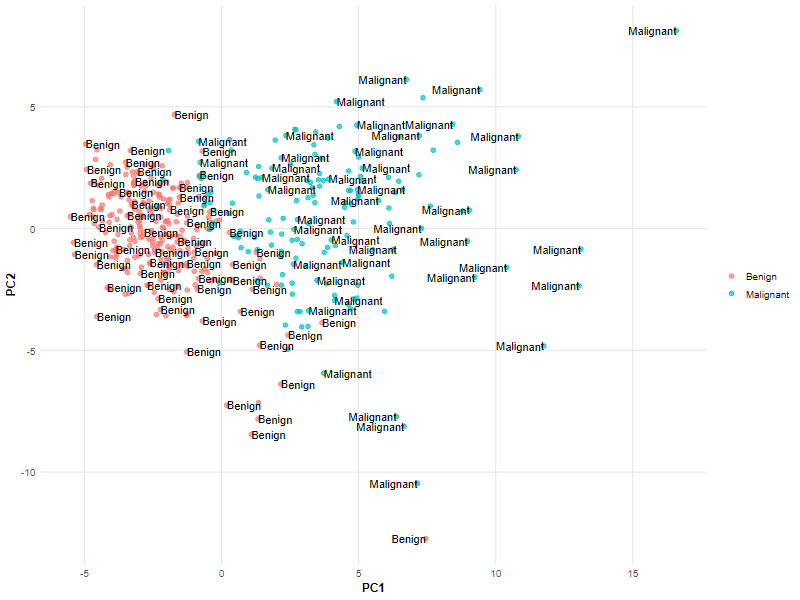

In [35]:
juice(pca_prep) %>%
  ggplot(aes(PC1, PC2, label = diagnosis)) +
  geom_point(aes(color = diagnosis), alpha = 0.7, size = 2) +
  geom_text(check_overlap = TRUE, hjust = "inward", family = "IBMPlexSans") +
  labs(color = NULL) -> pca_plot

print(pca_plot)

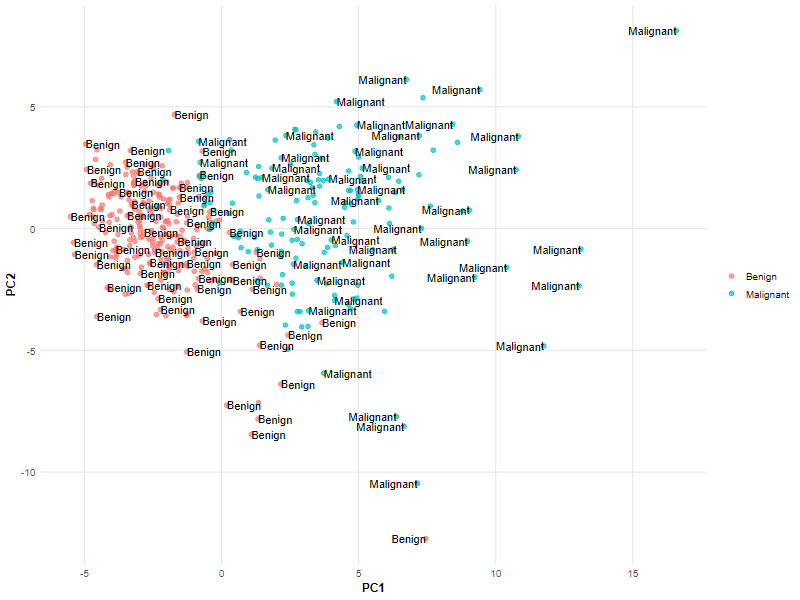

In [36]:
pca_plot

In [37]:
ggsave(
  filename = "pca separation plot.png",
  plot = pca_plot,
  path = "../results/",
  width = 10,  # Adjust as needed
  height = 8, # Adjust as needed
  dpi = 300   # Adjust as needed
)

In [38]:
cancer_recipe <- recipe(diagnosis ~ ., data = training) %>%
  # Remove highly correlated features
  step_corr(all_predictors(), threshold = 0.9) %>%
  # Center and scale all predictors
  step_center(all_predictors()) %>%
  step_scale(all_predictors()) %>%
  # Handle class imbalance
  themis::step_smote(diagnosis) %>%
  # Perform principal component analysis for dimension reduction and for visualization
  step_pca(all_predictors(), num_comp = 6, prefix = "PC")

In [39]:
library(doParallel)
library(earth)
library(baguette)
library(discrim)
cl <- makePSOCKcluster(detectCores() - 1)
registerDoParallel(cl)

tic()
rf_spec <- rand_forest(
  mtry = tune(),
  trees = 1000,
  min_n = tune()
) %>%
  set_engine("ranger", importance = "impurity") %>%
  set_mode("classification")


xgb_spec <- boost_tree(
  trees = 1000,
  tree_depth = tune(),
  min_n = tune(),
  loss_reduction = tune(),
  sample_size = tune(),
  mtry = tune(),
  learn_rate = tune()
) %>%
  set_engine("xgboost") %>%
  set_mode("classification")

svm_spec <- svm_rbf(
  cost = tune(),
  rbf_sigma = tune()
) %>%
  set_engine("kernlab") %>%
  set_mode("classification")

log_spec <- logistic_reg(
  penalty = tune(),
  mixture = tune()
) %>%
  set_engine("glmnet") %>%
  set_mode("classification")

bart_spec <-
  bart(trees = tune(), prior_terminal_node_coef = tune(), prior_terminal_node_expo = tune(), prior_outcome_range = tune()) %>%
  set_engine('dbarts') %>%
  set_mode('classification')

dt_spec <-
  decision_tree(tree_depth = tune(), min_n = tune(), cost_complexity = tune()) %>%
  set_engine('rpart') %>%
  set_mode('classification')

nnet_spec <-
  mlp(hidden_units = tune(), penalty = tune(), epochs = tune()) %>%
  set_engine('nnet') %>%
  set_mode('classification')

naivebayes_spec <-
  naive_Bayes(smoothness = tune(), Laplace = tune()) %>%
  set_engine('naivebayes') %>% 
  set_mode("classification")

kknn_spec <-
  nearest_neighbor(neighbors = tune(), weight_func = tune(), dist_power = tune()) %>%
  set_engine('kknn') %>%
  set_mode('classification')


# Define workflow sets
cancer_workflows <- workflow_set(
  preproc = list(cancer_recipe),
  models = list(
    rf = rf_spec,
    logistic = log_spec,
    svm = svm_spec,
    xgb = xgb_spec,
    bart = bart_spec,
    decision_tree = dt_spec,
    nnet = nnet_spec,
    naivebayes = naivebayes_spec,
    nearest_neighbors = kknn_spec
  )
)

metrics <- metric_set(yardstick::accuracy, roc_auc, yardstick::sensitivity, yardstick::specificity, brier_class)

race_ctrl <- control_race(
  save_pred = TRUE,
  parallel_over = "everything",
  save_workflow = TRUE
)
race_results <- cancer_workflows %>%
  workflow_map(
    seed = 42,
    fn = "tune_race_anova",
    resamples = cv_folds,
    grid = 25,
    metrics = metrics,
    control = race_ctrl
  )
stopCluster(cl)
toc()



Loading required package: foreach

Attaching package: ‘foreach’

The following objects are masked from ‘package:purrr’:

    accumulate, when

Loading required package: iterators
Loading required package: parallel
Loading required package: Formula
Loading required package: plotmo
Loading required package: plotrix

Attaching package: ‘plotrix’

The following object is masked from ‘package:scales’:

    rescale


Attaching package: ‘discrim’

The following object is masked from ‘package:dials’:

    smoothness

i Creating pre-processing data to finalize unknown parameter: mtry
i Creating pre-processing data to finalize unknown parameter: mtry
756.41 sec elapsed


In [40]:
race_results <- race_results %>% 
  mutate(wflow_id = gsub("recipe_", "", wflow_id))
race_results

# A workflow set/tibble: 9 × 4
  wflow_id          info             option    result   
  <chr>             <list>           <list>    <list>   
1 rf                <tibble [1 × 4]> <opts[4]> <race[+]>
2 logistic          <tibble [1 × 4]> <opts[4]> <race[+]>
3 svm               <tibble [1 × 4]> <opts[4]> <race[+]>
4 xgb               <tibble [1 × 4]> <opts[4]> <race[+]>
5 bart              <tibble [1 × 4]> <opts[4]> <race[+]>
6 decision_tree     <tibble [1 × 4]> <opts[4]> <race[+]>
7 nnet              <tibble [1 × 4]> <opts[4]> <race[+]>
8 naivebayes        <tibble [1 × 4]> <opts[4]> <race[+]>
9 nearest_neighbors <tibble [1 × 4]> <opts[4]> <race[+]>

In [41]:
race_results %>% 
  rank_results() %>% 
  filter(.metric == "accuracy") %>% 
  select(model, .config, accuracy = mean, rank)

# A tibble: 81 × 4
   model   .config               accuracy  rank
   <chr>   <chr>                    <dbl> <int>
 1 mlp     Preprocessor1_Model03    0.972     1
 2 mlp     Preprocessor1_Model23    0.967     2
 3 mlp     Preprocessor1_Model02    0.967     3
 4 svm_rbf Preprocessor1_Model17    0.967     4
 5 mlp     Preprocessor1_Model24    0.967     5
 6 mlp     Preprocessor1_Model01    0.965     6
 7 mlp     Preprocessor1_Model12    0.965     7
 8 mlp     Preprocessor1_Model08    0.965     8
 9 mlp     Preprocessor1_Model11    0.965     9
10 mlp     Preprocessor1_Model22    0.965    10
# ℹ 71 more rows
# ℹ Use `print(n = ...)` to see more rows

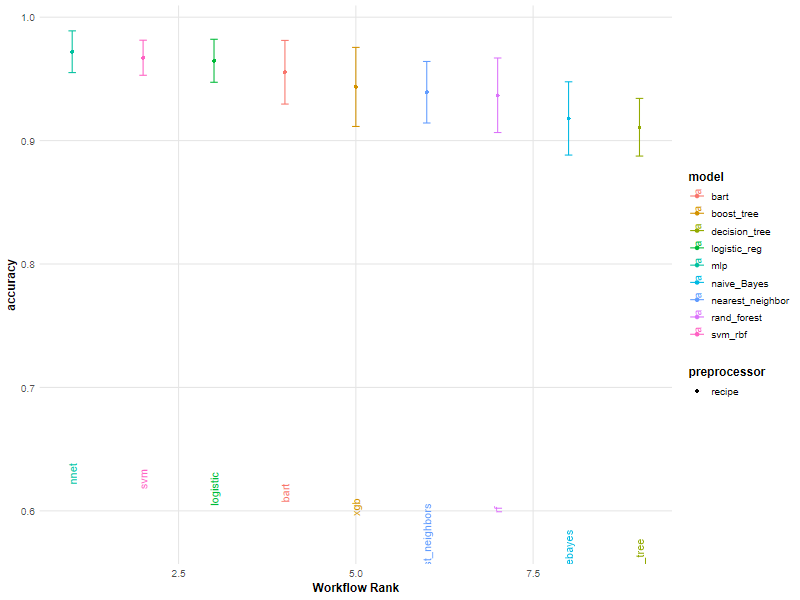

In [42]:
autoplot(race_results,
  rank_metric = "accuracy",
  metric = "accuracy",
  select_best = TRUE) +
  geom_text(aes(y = mean - 1/3, label = wflow_id), angle = 90, hjust = 1)  -> race_plot

race_plot

In [43]:
ggsave(
  filename = "model_race_results.png",
  plot = race_plot,
  path = "../results/",
  width = 12, 
  height = 8, 
  dpi = 300   
)

In [44]:
# Extract all metrics and predictions
all_metrics <- collect_metrics(race_results)
all_predictions <- collect_predictions(race_results)
# 1. Overall Performance Comparison
overall_comparison <- race_results %>%
  collect_metrics() %>%
  group_by(wflow_id, .metric) %>%
  summarise(
    mean_perf = mean(mean),
    sd_perf = sd(mean),
    .groups = "drop"
  ) %>%
  arrange(wflow_id, mean_perf)

overall_comparison

# A tibble: 45 × 4
   wflow_id      .metric     mean_perf sd_perf
   <chr>         <chr>           <dbl>   <dbl>
 1 bart          brier_class    0.0448 0.00703
 2 bart          specificity    0.928  0.00551
 3 bart          accuracy       0.950  0.00467
 4 bart          sensitivity    0.963  0.00674
 5 bart          roc_auc        0.992  0.00104
 6 decision_tree brier_class    0.0851 0.00629
 7 decision_tree specificity    0.877  0.0129 
 8 decision_tree accuracy       0.903  0.00679
 9 decision_tree sensitivity    0.918  0.0148 
10 decision_tree roc_auc        0.933  0.0121 
# ℹ 35 more rows
# ℹ Use `print(n = ...)` to see more rows

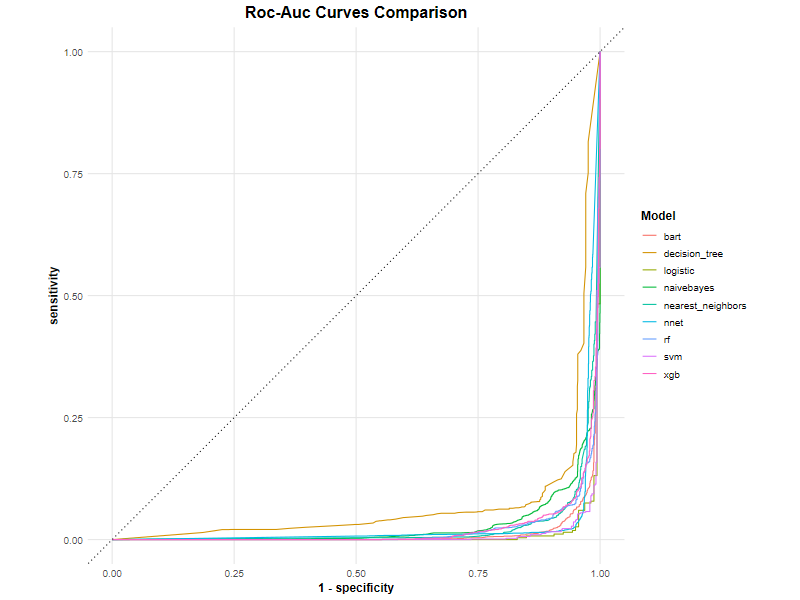

In [45]:
# 2. ROC Curves Comparison
roc_curves <- all_predictions %>%
  group_by(wflow_id) %>%
  roc_curve(truth = diagnosis, .pred_Malignant) %>%
  autoplot() +
  theme_custom() +
  labs(
      title = "Roc-Auc Curves Comparison",
      color = "Model"
    )
ggsave(
      filename = "Roc-Auc curves.png",
      plot = roc_curves,
      path = "../results/",
      width = 12,  
      height = 8, 
      dpi = 300   
)

roc_curves

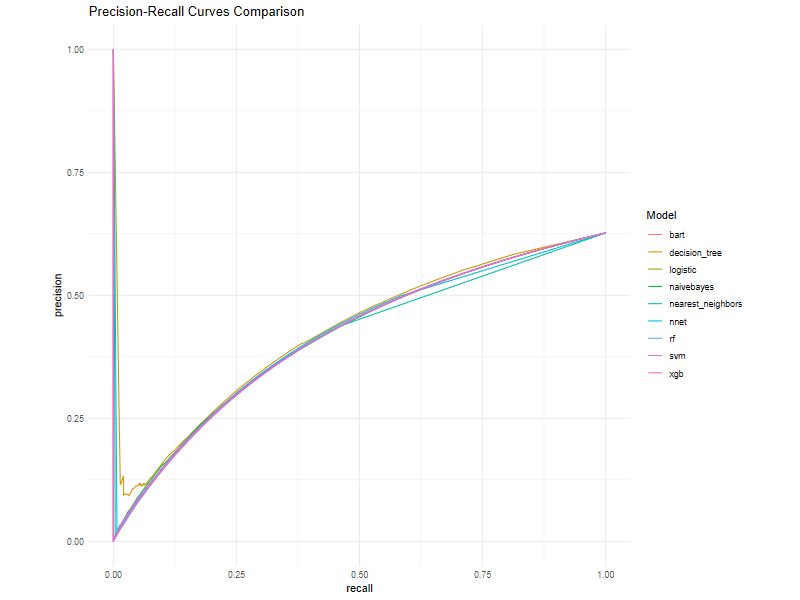

In [46]:
# 3. Precision-Recall Curves
pr_curves <- all_predictions %>%
  group_by(wflow_id) %>%
  pr_curve(truth = diagnosis, .pred_Malignant) %>%
  autoplot() +
  theme_minimal() +
  labs(
    title = "Precision-Recall Curves Comparison",
    color = "Model"
  )

  ggsave(
    filename = "Precision-Recall curves.png",
    plot = pr_curves,
    path = "../results/",
    width = 12,  
    height = 8, 
    dpi = 300   
)
pr_curves

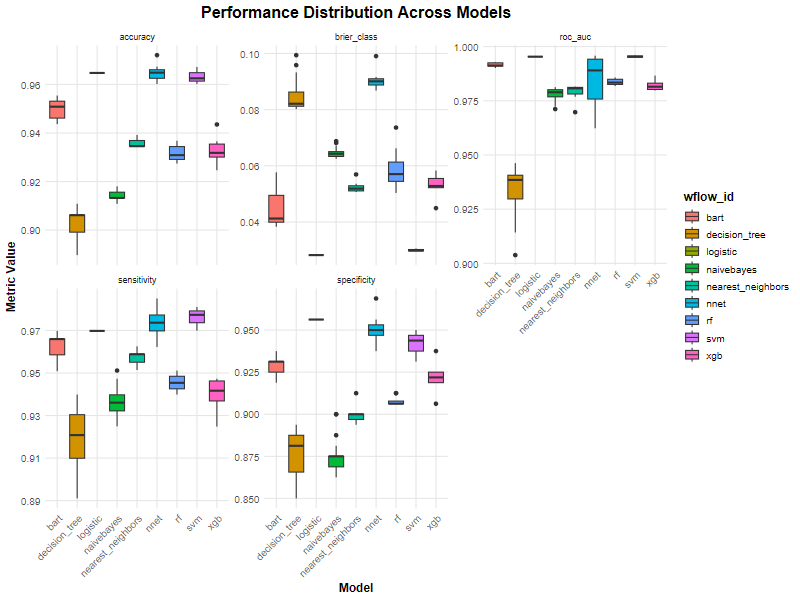

In [47]:
# 4. Performance Distribution Boxplots
metric_distributions <- all_metrics %>%
  ggplot(aes(x = wflow_id, y = mean, fill = wflow_id)) +
  geom_boxplot() +
  facet_wrap(~.metric, scales = "free_y") +
  theme(axis.text.x = element_text(angle = 45, hjust = 1)) +
  labs(
    title = "Performance Distribution Across Models",
    x = "Model",
    y = "Metric Value"
  )

  ggsave(
    filename = "Metric Distributions.png",
    plot = metric_distributions,
    path = "../results/",
    width = 12,  
    height = 8, 
    dpi = 300   
)
metric_distributions

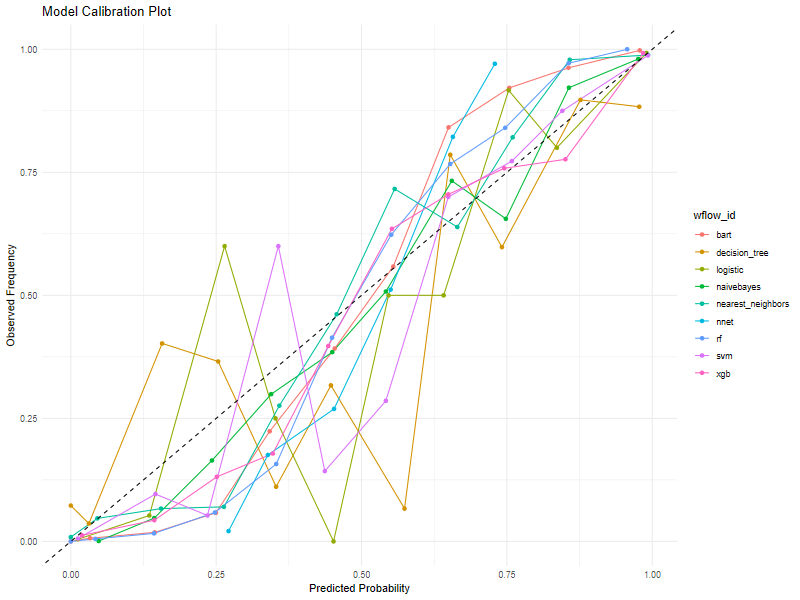

In [48]:
# 5. Model Calibration
calibration_plots <- all_predictions %>%
  group_by(wflow_id) %>%
  mutate(pred_bin = cut(.pred_Malignant, breaks = seq(0, 1, by = 0.1))) %>%
  group_by(wflow_id, pred_bin) %>%
  summarise(
    observed_prob = mean(diagnosis == "Malignant"),
    predicted_prob = mean(.pred_Malignant),
    .groups = "drop"
  ) %>%
  ggplot(aes(x = predicted_prob, y = observed_prob, color = wflow_id)) +
  geom_line() +
  geom_point() +
  geom_abline(linetype = "dashed") +  # Ideal calibration line
  theme_minimal() +
  labs(title = "Model Calibration Plot", x = "Predicted Probability", y = "Observed Frequency")
ggsave(
  filename = "Model Calibration Plot.png",
  plot = calibration_plots,
  path = "../results/",
  width = 12,  
  height = 8, 
  dpi = 300   
)
calibration_plots

In [49]:
# 6. Model Rankings
model_rankings <- all_metrics %>%
  group_by(.metric, wflow_id) %>%
  summarise(mean = mean(mean), .groups = "drop") %>%
  mutate(rank = rank(-mean)) %>%
  pivot_wider(names_from = .metric, values_from = c(mean, rank)) %>%
  arrange(rank_roc_auc) %>%
  kable(caption = "Average model rankings based on selected metrics")

print(model_rankings)




Table: Average model rankings based on selected metrics

|wflow_id          | mean_accuracy| mean_brier_class| mean_roc_auc| mean_sensitivity| mean_specificity| rank_accuracy| rank_brier_class| rank_roc_auc| rank_sensitivity| rank_specificity|
|:-----------------|-------------:|----------------:|------------:|----------------:|----------------:|-------------:|----------------:|------------:|----------------:|----------------:|
|svm               |     0.9632863|        0.0300270|    0.9954179|        0.9761159|        0.9416667|            14|               44|            1|                9|               21|
|logistic          |     0.9647233|        0.0282047|    0.9953526|        0.9698006|        0.9562500|            12|               45|            2|               11|               17|
|bart              |     0.9502117|        0.0448089|    0.9915262|        0.9630104|        0.9284722|            18|               43|            3|               15|               28|
|nnet 

In [50]:
# Ensure `wflow_id` is a factor (categorical variable)
all_metrics <- all_metrics %>%
  mutate(wflow_id = as.factor(wflow_id))

# Ensure each fold is treated as a blocking factor
# Create `id` to represent the blocking factor (folds)
all_metrics <- all_metrics %>%
  mutate(id = rep(1:floor(n()/length(unique(wflow_id))),
                  each = length(unique(wflow_id)), length.out = n()))

# Filter only rows where `.metric` is "roc_auc"
roc_metrics <- all_metrics %>%
  filter(.metric == "roc_auc")

# Ensure `mean` (roc_auc values) is numeric
roc_metrics <- roc_metrics %>%
  mutate(mean = as.numeric(mean))

# Check for missing values
missing_data <- roc_metrics %>%
  group_by(id, wflow_id) %>%
  summarise(n = n(), .groups = "drop") %>%
  pivot_wider(names_from = wflow_id, values_from = n)


# Create properly formatted data for Friedman test
friedman_data <- roc_metrics %>%
  select(id, wflow_id, mean) %>%  
  pivot_wider(
    names_from = wflow_id,
    values_from = mean
  )


# Perform Friedman test
friedman_result <- friedman.test(as.matrix(friedman_data[,-1]))

print("\nFriedman test results:")
print(friedman_result)

# If Friedman test is significant, perform post-hoc analysis
if(friedman_result$p.value < 0.05) {
  # Perform pairwise Wilcoxon signed rank tests with p-value adjustment
  posthoc <- all_metrics %>%
    wilcox_test(
      mean ~ wflow_id,
      paired = TRUE,
      p.adjust.method = "bonferroni"
    )
  
  print("\nPost-hoc analysis results:")
  print(posthoc)
}


Warning message:
Values from `mean` are not uniquely identified; output will contain list-cols.
• Use `values_fn = list` to suppress this warning.
• Use `values_fn = {summary_fun}` to summarise duplicates.
• Use the following dplyr code to identify duplicates.
  {data} |>
  dplyr::summarise(n = dplyr::n(), .by = c(id, wflow_id)) |>
  dplyr::filter(n > 1L) 


[1] "\nFriedman test results:"

	Friedman rank sum test

data:  as.matrix(friedman_data[, -1])
Friedman chi-squared = 3.3637, df = 8, p-value = 0.9095



Warning message:
Removed 4 rows containing missing values or values outside the scale range
(`geom_col()`). 
Warning message:
Removed 4 rows containing missing values or values outside the scale range
(`geom_col()`). 


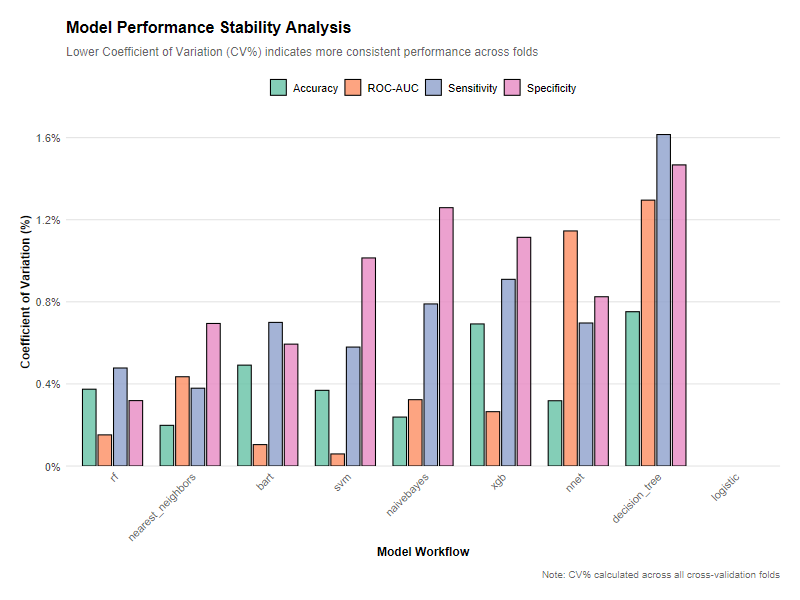

In [51]:
# Stability Plot Analysis
stability_plot <- all_metrics %>%
  # Filter for relevant metrics
  filter(.metric %in% c("accuracy", "roc_auc", "sensitivity", "specificity")) %>%
  # Calculate stability metrics
  group_by(wflow_id, .metric) %>%
  summarise(
    mean_perf = mean(mean),
    sd_perf = sd(mean),
    cv = sd_perf / mean_perf * 100,
    .groups = "drop"
  ) %>%
  # Create plot
  ggplot(aes(x = reorder(wflow_id, cv), y = cv, fill = .metric)) +
  geom_col(position = position_dodge(width = 0.8),
           width = 0.7,
           color = "black",
           alpha = 0.8) +
  # Custom color palette
  scale_fill_brewer(palette = "Set2",
                    labels = c("Accuracy", "ROC-AUC", "Sensitivity", "Specificity")) +
  # Formatting
  scale_y_continuous(
    #limits = c(0, max(cv) * 1.1),
    labels = function(x) paste0(round(x, 1), "%"),
    expand = expansion(mult = c(0, 0.05))
  ) +
  # Clean theme
  theme_minimal(base_size = 12, base_family = "Arial") +
  theme(
    plot.title = element_text(size = 16, face = "bold", margin = margin(b = 10)),
    plot.subtitle = element_text(size = 12, color = "grey40", margin = margin(b = 20)),
    plot.caption = element_text(size = 10, color = "grey40", margin = margin(t = 10)),
    axis.title = element_text(size = 12, face = "bold"),
    axis.text = element_text(size = 11),
    axis.text.x = element_text(angle = 45, hjust = 1, vjust = 1),
    legend.position = "top",
    legend.title = element_blank(),
    legend.text = element_text(size = 11),
    legend.margin = margin(b = 10),
    panel.grid.major.x = element_blank(),
    panel.grid.minor = element_blank(),
    panel.grid.major.y = element_line(color = "grey90"),
    plot.margin = margin(20, 20, 20, 20)
  ) +
  # Labels
  labs(
    title = "Model Performance Stability Analysis",
    subtitle = "Lower Coefficient of Variation (CV%) indicates more consistent performance across folds",
    x = "Model Workflow",
    y = "Coefficient of Variation (%)",
    caption = "Note: CV% calculated across all cross-validation folds"
  )

ggsave(
    filename = "Model Performance Stability Analysis.png",
    plot = stability_plot,
    path = "../results/",
    width = 12,  
    height = 8, 
    dpi = 300   
)
stability_plot

In [52]:
performance_table <- overall_comparison %>%
  arrange(desc(mean_perf)) %>% # Sort by performance
  kable(format = "html", digits = 3, caption = "<span style='font-weight: bold; background-color: rgb(16, 133, 243); color: white; padding: 5px;'>Top Performing Models</span>") %>%
  kable_styling(full_width = FALSE, bootstrap_options = c("striped", "hover", "condensed")) %>%
  row_spec(0, bold = TRUE) %>%  # Make header bold
  column_spec(2:3, width = "15em") # Adjust column width
# performance_table

<table class="table table-striped table-hover table-condensed" style="width: auto !important; margin-left: auto; margin-right: auto;">
<caption><span style="font-weight: bold; background-color: rgb(16, 133, 243); color: white; padding: 5px;">Top Performing Models</span></caption>
 <thead>
  <tr>
   <th style="text-align:left;font-weight: bold;"> wflow_id </th>
   <th style="text-align:left;font-weight: bold;"> .metric </th>
   <th style="text-align:right;font-weight: bold;"> mean_perf </th>
   <th style="text-align:right;font-weight: bold;"> sd_perf </th>
  </tr>
 </thead>
<tbody>
  <tr>
   <td style="text-align:left;"> logistic </td>
   <td style="text-align:left;width: 15em; "> roc_auc </td>
   <td style="text-align:right;width: 15em; "> 0.995 </td>
   <td style="text-align:right;"> 0.000 </td>
  </tr>
  <tr>
   <td style="text-align:left;"> svm </td>
   <td style="text-align:left;width: 15em; "> roc_auc </td>
   <td style="text-align:right;width: 15em; "> 0.994 </td>
   <td style="text-align:right;"> 0.001 </td>
  </tr>
  <tr>
   <td style="text-align:left;"> bart </td>
   <td style="text-align:left;width: 15em; "> roc_auc </td>
   <td style="text-align:right;width: 15em; "> 0.992 </td>
   <td style="text-align:right;"> 0.000 </td>
  </tr>
  <tr>
   <td style="text-align:left;"> nnet </td>
   <td style="text-align:left;width: 15em; "> roc_auc </td>
   <td style="text-align:right;width: 15em; "> 0.991 </td>
   <td style="text-align:right;"> 0.005 </td>
  </tr>
  <tr>
   <td style="text-align:left;"> rf </td>
   <td style="text-align:left;width: 15em; "> roc_auc </td>
   <td style="text-align:right;width: 15em; "> 0.987 </td>
   <td style="text-align:right;"> 0.000 </td>
  </tr>
  <tr>
   <td style="text-align:left;"> xgb </td>
   <td style="text-align:left;width: 15em; "> roc_auc </td>
   <td style="text-align:right;width: 15em; "> 0.985 </td>
   <td style="text-align:right;"> 0.002 </td>
  </tr>
  <tr>
   <td style="text-align:left;"> naivebayes </td>
   <td style="text-align:left;width: 15em; "> roc_auc </td>
   <td style="text-align:right;width: 15em; "> 0.982 </td>
   <td style="text-align:right;"> 0.001 </td>
  </tr>
  <tr>
   <td style="text-align:left;"> svm </td>
   <td style="text-align:left;width: 15em; "> sensitivity </td>
   <td style="text-align:right;width: 15em; "> 0.981 </td>
   <td style="text-align:right;"> 0.010 </td>
  </tr>
  <tr>
   <td style="text-align:left;"> nearest_neighbors </td>
   <td style="text-align:left;width: 15em; "> roc_auc </td>
   <td style="text-align:right;width: 15em; "> 0.978 </td>
   <td style="text-align:right;"> 0.004 </td>
  </tr>
  <tr>
   <td style="text-align:left;"> nnet </td>
   <td style="text-align:left;width: 15em; "> sensitivity </td>
   <td style="text-align:right;width: 15em; "> 0.969 </td>
   <td style="text-align:right;"> 0.007 </td>
  </tr>
  <tr>
   <td style="text-align:left;"> logistic </td>
   <td style="text-align:left;width: 15em; "> sensitivity </td>
   <td style="text-align:right;width: 15em; "> 0.969 </td>
   <td style="text-align:right;"> 0.002 </td>
  </tr>
  <tr>
   <td style="text-align:left;"> bart </td>
   <td style="text-align:left;width: 15em; "> sensitivity </td>
   <td style="text-align:right;width: 15em; "> 0.965 </td>
   <td style="text-align:right;"> 0.005 </td>
  </tr>
  <tr>
   <td style="text-align:left;"> logistic </td>
   <td style="text-align:left;width: 15em; "> accuracy </td>
   <td style="text-align:right;width: 15em; "> 0.963 </td>
   <td style="text-align:right;"> 0.001 </td>
  </tr>
  <tr>
   <td style="text-align:left;"> nnet </td>
   <td style="text-align:left;width: 15em; "> accuracy </td>
   <td style="text-align:right;width: 15em; "> 0.962 </td>
   <td style="text-align:right;"> 0.005 </td>
  </tr>
  <tr>
   <td style="text-align:left;"> svm </td>
   <td style="text-align:left;width: 15em; "> accuracy </td>
   <td style="text-align:right;width: 15em; "> 0.960 </td>
   <td style="text-align:right;"> 0.006 </td>
  </tr>
  <tr>
   <td style="text-align:left;"> nearest_neighbors </td>
   <td style="text-align:left;width: 15em; "> sensitivity </td>
   <td style="text-align:right;width: 15em; "> 0.959 </td>
   <td style="text-align:right;"> 0.005 </td>
  </tr>
  <tr>
   <td style="text-align:left;"> rf </td>
   <td style="text-align:left;width: 15em; "> sensitivity </td>
   <td style="text-align:right;width: 15em; "> 0.959 </td>
   <td style="text-align:right;"> 0.004 </td>
  </tr>
  <tr>
   <td style="text-align:left;"> bart </td>
   <td style="text-align:left;width: 15em; "> accuracy </td>
   <td style="text-align:right;width: 15em; "> 0.954 </td>
   <td style="text-align:right;"> 0.004 </td>
  </tr>
  <tr>
   <td style="text-align:left;"> logistic </td>
   <td style="text-align:left;width: 15em; "> specificity </td>
   <td style="text-align:right;width: 15em; "> 0.952 </td>
   <td style="text-align:right;"> 0.003 </td>
  </tr>
  <tr>
   <td style="text-align:left;"> nnet </td>
   <td style="text-align:left;width: 15em; "> specificity </td>
   <td style="text-align:right;width: 15em; "> 0.949 </td>
   <td style="text-align:right;"> 0.005 </td>
  </tr>
  <tr>
   <td style="text-align:left;"> xgb </td>
   <td style="text-align:left;width: 15em; "> sensitivity </td>
   <td style="text-align:right;width: 15em; "> 0.938 </td>
   <td style="text-align:right;"> 0.012 </td>
  </tr>
  <tr>
   <td style="text-align:left;"> nearest_neighbors </td>
   <td style="text-align:left;width: 15em; "> accuracy </td>
   <td style="text-align:right;width: 15em; "> 0.938 </td>
   <td style="text-align:right;"> 0.003 </td>
  </tr>
  <tr>
   <td style="text-align:left;"> naivebayes </td>
   <td style="text-align:left;width: 15em; "> sensitivity </td>
   <td style="text-align:right;width: 15em; "> 0.937 </td>
   <td style="text-align:right;"> 0.006 </td>
  </tr>
  <tr>
   <td style="text-align:left;"> rf </td>
   <td style="text-align:left;width: 15em; "> accuracy </td>
   <td style="text-align:right;width: 15em; "> 0.935 </td>
   <td style="text-align:right;"> 0.001 </td>
  </tr>
  <tr>
   <td style="text-align:left;"> bart </td>
   <td style="text-align:left;width: 15em; "> specificity </td>
   <td style="text-align:right;width: 15em; "> 0.935 </td>
   <td style="text-align:right;"> 0.009 </td>
  </tr>
  <tr>
   <td style="text-align:left;"> xgb </td>
   <td style="text-align:left;width: 15em; "> accuracy </td>
   <td style="text-align:right;width: 15em; "> 0.928 </td>
   <td style="text-align:right;"> 0.006 </td>
  </tr>
  <tr>
   <td style="text-align:left;"> decision_tree </td>
   <td style="text-align:left;width: 15em; "> sensitivity </td>
   <td style="text-align:right;width: 15em; "> 0.924 </td>
   <td style="text-align:right;"> 0.010 </td>
  </tr>
  <tr>
   <td style="text-align:left;"> svm </td>
   <td style="text-align:left;width: 15em; "> specificity </td>
   <td style="text-align:right;width: 15em; "> 0.923 </td>
   <td style="text-align:right;"> 0.033 </td>
  </tr>
  <tr>
   <td style="text-align:left;"> decision_tree </td>
   <td style="text-align:left;width: 15em; "> roc_auc </td>
   <td style="text-align:right;width: 15em; "> 0.920 </td>
   <td style="text-align:right;"> 0.009 </td>
  </tr>
  <tr>
   <td style="text-align:left;"> naivebayes </td>
   <td style="text-align:left;width: 15em; "> accuracy </td>
   <td style="text-align:right;width: 15em; "> 0.916 </td>
   <td style="text-align:right;"> 0.002 </td>
  </tr>
  <tr>
   <td style="text-align:left;"> xgb </td>
   <td style="text-align:left;width: 15em; "> specificity </td>
   <td style="text-align:right;width: 15em; "> 0.911 </td>
   <td style="text-align:right;"> 0.009 </td>
  </tr>
  <tr>
   <td style="text-align:left;"> nearest_neighbors </td>
   <td style="text-align:left;width: 15em; "> specificity </td>
   <td style="text-align:right;width: 15em; "> 0.903 </td>
   <td style="text-align:right;"> 0.007 </td>
  </tr>
  <tr>
   <td style="text-align:left;"> decision_tree </td>
   <td style="text-align:left;width: 15em; "> accuracy </td>
   <td style="text-align:right;width: 15em; "> 0.901 </td>
   <td style="text-align:right;"> 0.006 </td>
  </tr>
  <tr>
   <td style="text-align:left;"> rf </td>
   <td style="text-align:left;width: 15em; "> specificity </td>
   <td style="text-align:right;width: 15em; "> 0.895 </td>
   <td style="text-align:right;"> 0.009 </td>
  </tr>
  <tr>
   <td style="text-align:left;"> naivebayes </td>
   <td style="text-align:left;width: 15em; "> specificity </td>
   <td style="text-align:right;width: 15em; "> 0.879 </td>
   <td style="text-align:right;"> 0.003 </td>
  </tr>
  <tr>
   <td style="text-align:left;"> decision_tree </td>
   <td style="text-align:left;width: 15em; "> specificity </td>
   <td style="text-align:right;width: 15em; "> 0.861 </td>
   <td style="text-align:right;"> 0.005 </td>
  </tr>
  <tr>
   <td style="text-align:left;"> nnet </td>
   <td style="text-align:left;width: 15em; "> brier_class </td>
   <td style="text-align:right;width: 15em; "> 0.092 </td>
   <td style="text-align:right;"> 0.003 </td>
  </tr>
  <tr>
   <td style="text-align:left;"> decision_tree </td>
   <td style="text-align:left;width: 15em; "> brier_class </td>
   <td style="text-align:right;width: 15em; "> 0.085 </td>
   <td style="text-align:right;"> 0.002 </td>
  </tr>
  <tr>
   <td style="text-align:left;"> naivebayes </td>
   <td style="text-align:left;width: 15em; "> brier_class </td>
   <td style="text-align:right;width: 15em; "> 0.061 </td>
   <td style="text-align:right;"> 0.000 </td>
  </tr>
  <tr>
   <td style="text-align:left;"> nearest_neighbors </td>
   <td style="text-align:left;width: 15em; "> brier_class </td>
   <td style="text-align:right;width: 15em; "> 0.053 </td>
   <td style="text-align:right;"> 0.002 </td>
  </tr>
  <tr>
   <td style="text-align:left;"> rf </td>
   <td style="text-align:left;width: 15em; "> brier_class </td>
   <td style="text-align:right;width: 15em; "> 0.052 </td>
   <td style="text-align:right;"> 0.002 </td>
  </tr>
  <tr>
   <td style="text-align:left;"> xgb </td>
   <td style="text-align:left;width: 15em; "> brier_class </td>
   <td style="text-align:right;width: 15em; "> 0.051 </td>
   <td style="text-align:right;"> 0.005 </td>
  </tr>
  <tr>
   <td style="text-align:left;"> bart </td>
   <td style="text-align:left;width: 15em; "> brier_class </td>
   <td style="text-align:right;width: 15em; "> 0.041 </td>
   <td style="text-align:right;"> 0.004 </td>
  </tr>
  <tr>
   <td style="text-align:left;"> svm </td>
   <td style="text-align:left;width: 15em; "> brier_class </td>
   <td style="text-align:right;width: 15em; "> 0.030 </td>
   <td style="text-align:right;"> 0.001 </td>
  </tr>
  <tr>
   <td style="text-align:left;"> logistic </td>
   <td style="text-align:left;width: 15em; "> brier_class </td>
   <td style="text-align:right;width: 15em; "> 0.029 </td>
   <td style="text-align:right;"> 0.001 </td>
  </tr>
</tbody>
</table>

In [53]:
best_results <- race_results %>% 
  extract_workflow_set_result("nnet") %>% 
  select_best(metric = "accuracy")

print(best_results)



# A tibble: 1 × 4
  hidden_units penalty epochs .config              
         <int>   <dbl>  <int> <chr>                
1            6  0.0892    609 Preprocessor1_Model03


In [54]:
race_results %>% 
  extract_workflow("nnet") %>% 
  finalize_workflow(best_results) %>% 
  last_fit(split = splits) -> final_fit


Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.
[[1]]
# A tibble: 3 × 4
  .metric     .estimator .estimate .config             
  <chr>       <chr>          <dbl> <chr>               
1 accuracy    binary        0.951  Preprocessor1_Model1
2 roc_auc     binary        0.994  Preprocessor1_Model1
3 brier_class binary        0.0932 Preprocessor1_Model1

[[2]]



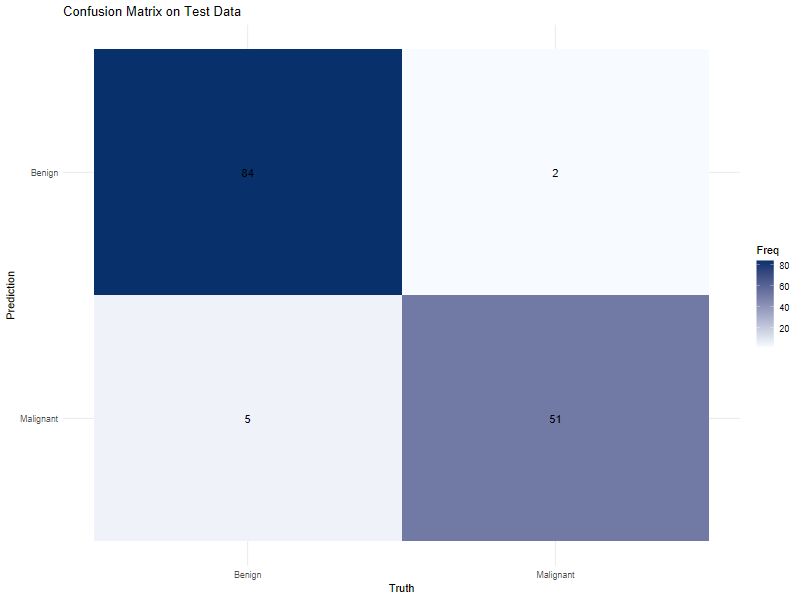

In [55]:
final_fit %>% 
  collect_predictions() %>% 
  conf_mat(truth = diagnosis, 
      estimate = .pred_class) -> conf_mat

confusion_matrix <- conf_mat %>%
  autoplot(type = "heatmap") +
  labs(title = "Confusion Matrix on Test Data") +
  scale_fill_gradient(low = "#f7fbff", high = "#08306b") +
  theme_minimal()
ggsave(filename = "../results/confusion_matrix.png", plot = confusion_matrix,
 width = 8, height = 6, dpi = 300)
confusion_matrix

final_metrics <- collect_metrics(final_fit)
print(list(final_metrics, confusion_matrix))



In [78]:
final_workflow <- final_fit$.workflow[[1]]

saveRDS(final_workflow, "nnet_final_model.rds")

In [58]:
library(sessioninfo)
session_info(
  pkgs = c("loaded", "attached", "installed")[1],
  include_base = FALSE,
  info = c("auto", "all", "platform", "packages", "python", "external"),
  dependencies = NA,
  to_file = FALSE
)

ERROR: Unknown command "TMPDIR=C:/Users/oland/AppData/Local/Temp/RtmpUN9xiN/file1dbc10737913". Did you mean command "pandoc"?


Warning message:
In system2("quarto", "-V", stdout = TRUE, env = paste0("TMPDIR=",  :
  running command '"quarto" TMPDIR=C:/Users/oland/AppData/Local/Temp/RtmpUN9xiN/file1dbc10737913 -V' had status 1


─ Session info ───────────────────────────────────────────────────────────────
 setting  value
 version  R version 4.4.2 (2024-10-31 ucrt)
 os       Windows 11 x64 (build 26100)
 system   x86_64, mingw32
 ui       Rgui
 language (EN)
 collate  English_Kenya.utf8
 ctype    English_Kenya.utf8
 tz       Africa/Nairobi
 date     2025-02-27
 pandoc   3.4 @ c:\\Program Files\\Positron\\resources\\app\\quarto\\bin\\tools/ (via rmarkdown)
 quarto   NA @ c:\\PROGRA~1\\Positron\\RESOUR~1\\app\\quarto\\bin\\quarto.exe

─ Packages ───────────────────────────────────────────────────────────────────
 package      * version    date (UTC) lib source
 abind          1.4-8      2024-09-12 [1] CRAN (R 4.4.1)
 backports      1.5.0      2024-05-23 [1] CRAN (R 4.4.0)
 baguette     * 1.1.0      2025-01-28 [1] CRAN (R 4.4.2)
 base64enc      0.1-3      2015-07-28 [1] CRAN (R 4.4.0)
 bayestestR     0.15.0     2024-10-17 [1] CRAN (R 4.4.2)
 betacal      * 0.1.0      2017-02-25 [1] CRAN (R 4.4.0)
 bit            